In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from nn_utilities import read_train_test, bootstrapped_cv, create_and_save_training_testing_data
from fd_model_nn import FD_Network
from utilities import plot_fd_and_original, plot_fd_and_speeds
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
def get_all_result_data(results):
    tr_mean = []
    tr_std = []
    val_mean = []
    val_std = []
    test_mean = []
    test_std = []
    for key in results.keys():
        tr_mean.append(results[key]['tr'][0])
        tr_std.append(results[key]['tr'][1])
        val_mean.append(results[key]['val'][0])
        val_std.append(results[key]['val'][1])
        test_mean.append(results[key]['test'][0])
        test_std.append(results[key]['test'][1])
    return tr_mean, tr_std, val_mean, val_std, test_mean, test_std

def plot_results(results, tr_mean, tr_std, val_mean, val_std, test_mean, test_std, plot_val=False, title=""):
    fig, ax = plt.subplots()
    ax.fill_between(range(len(tr_std)), [tr_mean[i]+tr_std[i] for i in range(len(tr_std))], [tr_mean[i]-tr_std[i] for i in range(len(tr_std))], alpha=0.2, color='orange')
    ax.plot(tr_mean, label='training_loss', c='orange')
    ax.scatter(range(len(tr_mean)), tr_mean, c='orange')
    
    if plot_val:
        ax.fill_between(range(len(val_std)), [val_mean[i]+val_std[i] for i in range(len(val_std))], [val_mean[i]-val_std[i] for i in range(len(val_std))], alpha=0.2)
        ax.plot(val_mean, label='validation_loss')
        ax.scatter(range(len(val_mean)), val_mean, c='blue')

    ax.fill_between(range(len(test_std)), [test_mean[i]+test_std[i] for i in range(len(test_std))], [test_mean[i]-test_std[i] for i in range(len(test_std))], alpha=0.2, color='red')
    ax.plot(test_mean, label='testing_loss', c='red')
    ax.scatter(range(len(test_mean)), test_mean, c='red')
    plt.legend()
    ax.set_ylabel('MSE')
    ax.set_xlabel('model conf')
    ax.set_xticks(range(len(results.keys())), labels=results.keys())
    plt.title(title)
    plt.show()

def train_both_models(task_train, task_test):
    base_path = "../data/training_data/"
    
    X_t, y_t = None, None
    fd_x_t = None
    for train_data in task_train:
        training_path = base_path + f"train_{train_data}_data"
        try:
            f = open(training_path)
        except IOError:
            create_and_save_training_testing_data(train_data, base_path)

        X_train, y_train, _, _ = read_train_test(train_data, base_path)
        fd_x_train = X_train[:,0].reshape(-1,1)
        
        if X_t is None:
            X_t = X_train
            y_t = y_train
            fd_x_t = fd_x_train
        else:
            X_t = np.concatenate((X_t, X_train), axis=0)
            y_t = np.concatenate((y_t, y_train), axis=0)
            fd_x_t = np.concatenate((fd_x_t, fd_x_train), axis=0)
    
    X_train, y_train, fd_x_train = X_t, y_t, fd_x_t
    
    X_t, y_t = None, None
    fd_x_t = None
    for test_data in task_test:
        testing_path = base_path + f"train_{test_data}_data"
        try:
            f = open(testing_path)
        except IOError:
            create_and_save_training_testing_data(test_data, base_path)

        _, _, X_test, y_test = read_train_test(test_data, base_path)
        fd_x_test = X_test[:,0].reshape(-1,1)
        
        if X_t is None:
            X_t = X_test
            y_t = y_test
            fd_x_t = fd_x_test
        else:
            X_t = np.concatenate((X_t, X_test), axis=0)
            y_t = np.concatenate((y_t, y_test), axis=0)
            fd_x_t = np.concatenate((fd_x_t, fd_x_test), axis=0)
    X_test, y_test, fd_x_test = X_t, y_t, fd_x_t
            
    # train fd
    model = FD_Network()
    fd_losses = bootstrapped_cv(hidden_dims=None, data=fd_x_train, targets=y_train,
                                                         test_data=fd_x_test, test_targets=y_test,
                                                         kfolds=5, epochs=1000, batch_size=32, n_bootstraps=15,
                                                         bootstrap_dim=1000, model=model)
    # train speed nn
    hidden_dims = [(3,)]
    nn_losses = bootstrapped_cv(hidden_dims=(3,), data=X_train, targets=y_train,
                                                     test_data=X_test, test_targets=y_test,
                                                     kfolds=5, epochs=1000, batch_size=32, n_bootstraps=15,
                                                     bootstrap_dim=1000)
    return nn_losses, fd_losses

# TRYING DIFFERENT TRAINING/TESTING SITUATIONS

In [3]:
import tensorflow as tf


class FD_Network(tf.keras.Model):
    """
    network to train a model approximating the Weidmann Model on given data
    """
    def __init__(self):
        """
        initialize the network, very simple feed forward network with 3 parameter outputs
        """
        super(FD_Network, self).__init__()
        self.hidden_layer = tf.keras.layers.Dense(3)
        # output layers producing the 3 parameters of the FD
        self.desired_speed = tf.keras.layers.Dense(1)
        self.pedestrian_size = tf.keras.layers.Dense(1)
        self.time_gap = tf.keras.layers.Dense(1)
        self.FD_model_parameters = {'t': [], 'l': [], 'v0': []}
        self.mse = -1

    def call(self, mean_spacing):
        """
        execute the feedforward, create the fd function from the parameters, return the predicted speed
        :param mean_spacing: only input of the net
        :return: predicted speed
        """
        x = self.hidden_layer(mean_spacing)
        x = tf.keras.activations.sigmoid(x)
        v0 = self.desired_speed(x)
        v0 = tf.keras.activations.softplus(v0)  # if bidirectional not needed!
        l = self.pedestrian_size(x)
        l = tf.keras.activations.softplus(l)
        t = self.time_gap(x)
        t = tf.keras.activations.softplus(t)
        self.FD_model_parameters['t'].append(tf.math.reduce_mean(t))
        self.FD_model_parameters['l'].append(tf.math.reduce_mean(l))
        self.FD_model_parameters['v0'].append(tf.math.reduce_mean(v0))
        return v0 * (1 - tf.exp((l - mean_spacing) / (v0 * t)))


In [4]:
nn_total_losses = {}
fd_total_losses = {}
corridor = 'corridor_140'
bottleneck = 'bottleneck_120'

In [5]:
# trying corridor140/corridor140
task = [corridor]
nn_losses, fd_losses = train_both_models(task_train=task, task_test=task)
nn_total_losses[f'{corridor}-{corridor}'] = nn_losses['test']
fd_total_losses[f'{corridor}-{corridor}'] = fd_losses['test']

Epoch 1/1000
25/25 [==============================] - 1s 11ms/step - loss: 0.1909 - val_loss: 0.1638
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1589 - val_loss: 0.1372
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1329 - val_loss: 0.1159
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.1118 - val_loss: 0.0988
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0945 - val_loss: 0.0853
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0805 - val_loss: 0.0744
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0693 - val_loss: 0.0662
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0607 - val_loss: 0.0603
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0543 - val_loss: 0.0569
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0501 - val_loss: 0.055

25/25 [==============================] - 0s 2ms/step - loss: 0.0325 - val_loss: 0.0405
Epoch 163/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0325 - val_loss: 0.0405
Epoch 164/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0325 - val_loss: 0.0405
Epoch 165/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0325 - val_loss: 0.0406
Epoch 166/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0325 - val_loss: 0.0405
Epoch 167/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0325 - val_loss: 0.0405
Epoch 168/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0325 - val_loss: 0.0405
Epoch 169/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0325 - val_loss: 0.0405
Epoch 170/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0325 - val_loss: 0.0406
Epoch 171/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0325 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0349 - val_loss: 0.0296
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0349 - val_loss: 0.0296
Epoch 12/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0349 - val_loss: 0.0297
Epoch 1/1000
25/25 [==============================] - 1s 9ms/step - loss: 0.0346 - val_loss: 0.0313
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0345 - val_loss: 0.0315
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0345 - val_loss: 0.0314
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0345 - val_loss: 0.0314
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0345 - val_loss: 0.0314
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0345 - val_loss: 0.0313
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0345 - val_loss: 0.0314
Epoch 8/100

25/25 [==============================] - 0s 4ms/step - loss: 0.0342 - val_loss: 0.0333
Epoch 18/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0342 - val_loss: 0.0332
Epoch 1/1000
25/25 [==============================] - 1s 9ms/step - loss: 0.0347 - val_loss: 0.0352
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0346 - val_loss: 0.0352
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0345 - val_loss: 0.0352
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0345 - val_loss: 0.0352
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0345 - val_loss: 0.0352
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0345 - val_loss: 0.0352
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0345 - val_loss: 0.0352
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0345 - val_loss: 0.0352
Epoch 9/1000

25/25 [==============================] - 0s 3ms/step - loss: 0.0340 - val_loss: 0.0348
Epoch 161/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0340 - val_loss: 0.0347
Epoch 162/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0340 - val_loss: 0.0348
Epoch 163/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0340 - val_loss: 0.0348
Epoch 164/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0339 - val_loss: 0.0348
Epoch 165/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0339 - val_loss: 0.0347
Epoch 166/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0339 - val_loss: 0.0347
Epoch 167/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0340 - val_loss: 0.0347
Epoch 168/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0339 - val_loss: 0.0347
Epoch 169/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0339 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0337 - val_loss: 0.0345
Epoch 321/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0337 - val_loss: 0.0345
Epoch 322/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0337 - val_loss: 0.0345
Epoch 323/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0337 - val_loss: 0.0344
Epoch 324/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0337 - val_loss: 0.0344
Epoch 325/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0337 - val_loss: 0.0344
Epoch 326/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0336 - val_loss: 0.0344
Epoch 327/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0337 - val_loss: 0.0344
Epoch 328/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0336 - val_loss: 0.0344
Epoch 329/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0336 - val_loss: 0.

25/25 [==============================] - 0s 3ms/step - loss: 0.0340 - val_loss: 0.0320
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0340 - val_loss: 0.0320
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0340 - val_loss: 0.0320
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0340 - val_loss: 0.0320
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0340 - val_loss: 0.0320
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0340 - val_loss: 0.0320
Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0340 - val_loss: 0.0320
Epoch 1/1000
25/25 [==============================] - 1s 10ms/step - loss: 0.0327 - val_loss: 0.0376
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0326 - val_loss: 0.0378
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0326 - val_loss: 0.0378
Epoch 4/10

Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0305 - val_loss: 0.0324
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0305 - val_loss: 0.0326
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0305 - val_loss: 0.0327
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0304 - val_loss: 0.0327
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0304 - val_loss: 0.0329
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0304 - val_loss: 0.0329
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0304 - val_loss: 0.0329
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0304 - val_loss: 0.0330
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0304 - val_loss: 0.0331
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0303 - val_loss: 0.033

25/25 [==============================] - 0s 3ms/step - loss: 0.0312 - val_loss: 0.0314
Epoch 111/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0312 - val_loss: 0.0314
Epoch 112/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0312 - val_loss: 0.0314
Epoch 113/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0312 - val_loss: 0.0314
Epoch 114/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0312 - val_loss: 0.0314
Epoch 115/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0312 - val_loss: 0.0314
Epoch 116/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0312 - val_loss: 0.0314
Epoch 117/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0312 - val_loss: 0.0314
Epoch 118/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0312 - val_loss: 0.0314
Epoch 119/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0312 - val_loss: 0.

25/25 [==============================] - 0s 3ms/step - loss: 0.0309 - val_loss: 0.0308
Epoch 271/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0309 - val_loss: 0.0308
Epoch 272/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0309 - val_loss: 0.0308
Epoch 273/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0309 - val_loss: 0.0308
Epoch 274/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0309 - val_loss: 0.0308
Epoch 275/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0309 - val_loss: 0.0308
Epoch 276/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0309 - val_loss: 0.0308
Epoch 277/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0309 - val_loss: 0.0308
Epoch 278/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0309 - val_loss: 0.0308
Epoch 279/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0309 - val_loss: 0.

25/25 [==============================] - 0s 3ms/step - loss: 0.0325 - val_loss: 0.0230
Epoch 1/1000
25/25 [==============================] - 1s 9ms/step - loss: 0.0353 - val_loss: 0.0227
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0352 - val_loss: 0.0227
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0351 - val_loss: 0.0227
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0352 - val_loss: 0.0227
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0351 - val_loss: 0.0228
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0351 - val_loss: 0.0228
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0351 - val_loss: 0.0227
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0351 - val_loss: 0.0228
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0351 - val_loss: 0.0227
Epoch 10/1000

Epoch 12/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0334 - val_loss: 0.0327
Epoch 13/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0334 - val_loss: 0.0327
Epoch 14/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0334 - val_loss: 0.0326
Epoch 15/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0333 - val_loss: 0.0326
Epoch 16/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0333 - val_loss: 0.0326
Epoch 17/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0333 - val_loss: 0.0325
Epoch 18/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0333 - val_loss: 0.0325
Epoch 19/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0333 - val_loss: 0.0325
Epoch 20/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0333 - val_loss: 0.0324
Epoch 21/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0333 - val_los

Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0325 - val_loss: 0.0360
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0325 - val_loss: 0.0360
Epoch 9/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0325 - val_loss: 0.0360
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0325 - val_loss: 0.0360
Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0325 - val_loss: 0.0360
Epoch 12/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0325 - val_loss: 0.0360
Epoch 1/1000
25/25 [==============================] - 1s 9ms/step - loss: 0.0328 - val_loss: 0.0345
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0326 - val_loss: 0.0347
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0325 - val_loss: 0.0350
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0324 - val_loss: 0.03

25/25 [==============================] - 0s 4ms/step - loss: 0.0381 - val_loss: 0.0330
Epoch 1/1000
25/25 [==============================] - 1s 11ms/step - loss: 0.0382 - val_loss: 0.0327
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0382 - val_loss: 0.0326
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0382 - val_loss: 0.0327
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0381 - val_loss: 0.0327
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0381 - val_loss: 0.0327
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0381 - val_loss: 0.0327
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0381 - val_loss: 0.0328
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0381 - val_loss: 0.0328
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0381 - val_loss: 0.0328
Epoch 10/100

Epoch 15/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0321 - val_loss: 0.0281
Epoch 16/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0321 - val_loss: 0.0282
Epoch 17/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0321 - val_loss: 0.0282
Epoch 18/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0321 - val_loss: 0.0281
Epoch 19/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0321 - val_loss: 0.0282
Epoch 20/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0321 - val_loss: 0.0281
Epoch 21/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0321 - val_loss: 0.0282
Epoch 1/1000
25/25 [==============================] - 1s 9ms/step - loss: 0.0321 - val_loss: 0.0284
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0320 - val_loss: 0.0284
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0320 - val_loss: 

25/25 [==============================] - 0s 3ms/step - loss: 0.0355 - val_loss: 0.0318
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0355 - val_loss: 0.0318
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0355 - val_loss: 0.0318
Epoch 6/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0355 - val_loss: 0.0318
Epoch 7/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0355 - val_loss: 0.0318
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0355 - val_loss: 0.0318
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0355 - val_loss: 0.0318
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0355 - val_loss: 0.0319
Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0355 - val_loss: 0.0319
Epoch 1/1000
25/25 [==============================] - 1s 9ms/step - loss: 0.0343 - val_loss: 0.0365
Epoch 2/100

Epoch 143/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0344 - val_loss: 0.0416
Epoch 144/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0343 - val_loss: 0.0413
Epoch 145/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0340 - val_loss: 0.0414
Epoch 146/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0339 - val_loss: 0.0410
Epoch 147/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0337 - val_loss: 0.0409
Epoch 148/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0335 - val_loss: 0.0405
Epoch 149/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0333 - val_loss: 0.0405
Epoch 150/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0332 - val_loss: 0.0404
Epoch 151/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0330 - val_loss: 0.0398
Epoch 152/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0328

25/25 [==============================] - 0s 2ms/step - loss: 0.0246 - val_loss: 0.0278
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0245 - val_loss: 0.0280
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0244 - val_loss: 0.0280
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0244 - val_loss: 0.0281
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0244 - val_loss: 0.0281
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0244 - val_loss: 0.0284
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0243 - val_loss: 0.0283
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0243 - val_loss: 0.0283
Epoch 1/1000
25/25 [==============================] - 1s 8ms/step - loss: 0.0261 - val_loss: 0.0227
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0256 - val_loss: 0.0225
Epoch 3/100

Epoch 131/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0370 - val_loss: 0.0403
Epoch 132/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0370 - val_loss: 0.0402
Epoch 133/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0368 - val_loss: 0.0404
Epoch 134/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0368 - val_loss: 0.0403
Epoch 135/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0366 - val_loss: 0.0400
Epoch 136/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0366 - val_loss: 0.0402
Epoch 137/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0364 - val_loss: 0.0403
Epoch 138/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0364 - val_loss: 0.0402
Epoch 139/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0362 - val_loss: 0.0403
Epoch 140/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0362

25/25 [==============================] - 0s 2ms/step - loss: 0.0602 - val_loss: 0.0752
Epoch 105/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0601 - val_loss: 0.0751
Epoch 106/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0600 - val_loss: 0.0751
Epoch 107/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0599 - val_loss: 0.0749
Epoch 108/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0598 - val_loss: 0.0749
Epoch 109/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0597 - val_loss: 0.0747
Epoch 110/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0596 - val_loss: 0.0746
Epoch 111/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0595 - val_loss: 0.0746
Epoch 112/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0594 - val_loss: 0.0744
Epoch 113/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0594 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0393 - val_loss: 0.0506
Epoch 265/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0390 - val_loss: 0.0505
Epoch 266/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0389 - val_loss: 0.0501
Epoch 267/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0387 - val_loss: 0.0499
Epoch 268/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0386 - val_loss: 0.0499
Epoch 269/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0384 - val_loss: 0.0496
Epoch 270/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0382 - val_loss: 0.0495
Epoch 271/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0381 - val_loss: 0.0491
Epoch 272/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0379 - val_loss: 0.0490
Epoch 273/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0378 - val_loss: 0.

25/25 [==============================] - 0s 3ms/step - loss: 0.0245 - val_loss: 0.0382
Epoch 425/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0244 - val_loss: 0.0383
Epoch 426/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0244 - val_loss: 0.0385
Epoch 427/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0243 - val_loss: 0.0383
Epoch 428/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0243 - val_loss: 0.0383
Epoch 429/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0244 - val_loss: 0.0382
Epoch 430/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0242 - val_loss: 0.0382
Epoch 431/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0242 - val_loss: 0.0383
Epoch 432/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0242 - val_loss: 0.0384
Epoch 433/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0241 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0439 - val_loss: 0.0569
Epoch 79/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0436 - val_loss: 0.0562
Epoch 80/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0432 - val_loss: 0.0557
Epoch 81/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0428 - val_loss: 0.0555
Epoch 82/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0424 - val_loss: 0.0550
Epoch 83/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0422 - val_loss: 0.0545
Epoch 84/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0417 - val_loss: 0.0538
Epoch 85/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0414 - val_loss: 0.0535
Epoch 86/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0411 - val_loss: 0.0533
Epoch 87/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0408 - val_loss: 0.0523
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0263 - val_loss: 0.0353
Epoch 239/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0263 - val_loss: 0.0355
Epoch 240/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0263 - val_loss: 0.0353
Epoch 241/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0263 - val_loss: 0.0350
Epoch 242/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0261 - val_loss: 0.0350
Epoch 243/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0262 - val_loss: 0.0351
Epoch 244/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0262 - val_loss: 0.0348
Epoch 245/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0261 - val_loss: 0.0348
Epoch 246/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0262 - val_loss: 0.0349
Epoch 247/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0260 - val_loss: 0.

Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0238 - val_loss: 0.0233
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0238 - val_loss: 0.0232
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0237 - val_loss: 0.0237
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0237 - val_loss: 0.0235
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0238 - val_loss: 0.0234
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0237 - val_loss: 0.0234
Epoch 1/1000
25/25 [==============================] - 1s 7ms/step - loss: 0.0240 - val_loss: 0.0229
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0238 - val_loss: 0.0229
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0237 - val_loss: 0.0230
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0237 - val_loss: 0.023

Epoch 146/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0529 - val_loss: 0.0637
Epoch 147/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0526 - val_loss: 0.0634
Epoch 148/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0524 - val_loss: 0.0630
Epoch 149/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0522 - val_loss: 0.0630
Epoch 150/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0521 - val_loss: 0.0625
Epoch 151/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0518 - val_loss: 0.0623
Epoch 152/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0516 - val_loss: 0.0615
Epoch 153/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0513 - val_loss: 0.0612
Epoch 154/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0512 - val_loss: 0.0608
Epoch 155/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0509

25/25 [==============================] - 0s 2ms/step - loss: 0.0343 - val_loss: 0.0288
Epoch 1/1000
25/25 [==============================] - 1s 7ms/step - loss: 0.0333 - val_loss: 0.0331
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0330 - val_loss: 0.0336
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0329 - val_loss: 0.0340
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0327 - val_loss: 0.0344
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0327 - val_loss: 0.0344
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0327 - val_loss: 0.0345
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0326 - val_loss: 0.0346
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0327 - val_loss: 0.0348
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0327 - val_loss: 0.0348
Epoch 10/1000

Epoch 129/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0408 - val_loss: 0.0449
Epoch 130/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0406 - val_loss: 0.0446
Epoch 131/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0405 - val_loss: 0.0446
Epoch 132/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0403 - val_loss: 0.0442
Epoch 133/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0401 - val_loss: 0.0441
Epoch 134/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0399 - val_loss: 0.0439
Epoch 135/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0397 - val_loss: 0.0438
Epoch 136/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0396 - val_loss: 0.0435
Epoch 137/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0394 - val_loss: 0.0433
Epoch 138/1000
25/25 [==============================] - ETA: 0s - loss: 0.028 - 0s

25/25 [==============================] - 0s 2ms/step - loss: 0.0300 - val_loss: 0.0328
Epoch 210/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0299 - val_loss: 0.0326
Epoch 211/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0299 - val_loss: 0.0327
Epoch 212/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0298 - val_loss: 0.0326
Epoch 213/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0297 - val_loss: 0.0325
Epoch 214/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0296 - val_loss: 0.0324
Epoch 215/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0295 - val_loss: 0.0325
Epoch 216/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0295 - val_loss: 0.0322
Epoch 217/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0293 - val_loss: 0.0322
Epoch 218/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0294 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0240 - val_loss: 0.0235
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0239 - val_loss: 0.0238
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0239 - val_loss: 0.0239
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0239 - val_loss: 0.0238
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0238 - val_loss: 0.0241
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0238 - val_loss: 0.0241
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0237 - val_loss: 0.0241
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0236 - val_loss: 0.0242
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0236 - val_loss: 0.0243
Epoch 1/1000
25/25 [==============================] - 1s 7ms/step - loss: 0.0240 - val_loss: 0.0236
Epoch 2/100

Epoch 120/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0619 - val_loss: 0.0542
Epoch 121/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0617 - val_loss: 0.0540
Epoch 122/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0616 - val_loss: 0.0539
Epoch 123/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0614 - val_loss: 0.0538
Epoch 124/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0612 - val_loss: 0.0537
Epoch 125/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0610 - val_loss: 0.0536
Epoch 126/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0609 - val_loss: 0.0535
Epoch 127/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0607 - val_loss: 0.0534
Epoch 128/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0605 - val_loss: 0.0532
Epoch 129/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0603

25/25 [==============================] - 0s 3ms/step - loss: 0.0277 - val_loss: 0.0302
Epoch 281/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0276 - val_loss: 0.0301
Epoch 282/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0276 - val_loss: 0.0300
Epoch 283/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0274 - val_loss: 0.0302
Epoch 284/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0274 - val_loss: 0.0299
Epoch 285/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0272 - val_loss: 0.0301
Epoch 286/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0273 - val_loss: 0.0297
Epoch 287/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0271 - val_loss: 0.0299
Epoch 288/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0270 - val_loss: 0.0298
Epoch 289/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0269 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0711 - val_loss: 0.0961
Epoch 16/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0697 - val_loss: 0.0945
Epoch 17/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0685 - val_loss: 0.0935
Epoch 18/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0675 - val_loss: 0.0919
Epoch 19/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0663 - val_loss: 0.0913
Epoch 20/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0654 - val_loss: 0.0903
Epoch 21/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0646 - val_loss: 0.0896
Epoch 22/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0637 - val_loss: 0.0886
Epoch 23/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0630 - val_loss: 0.0880
Epoch 24/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0623 - val_loss: 0.0868
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0261 - val_loss: 0.0411
Epoch 177/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0260 - val_loss: 0.0405
Epoch 178/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0258 - val_loss: 0.0408
Epoch 179/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0259 - val_loss: 0.0407
Epoch 180/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0257 - val_loss: 0.0405
Epoch 181/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0257 - val_loss: 0.0403
Epoch 182/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0256 - val_loss: 0.0402
Epoch 183/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0255 - val_loss: 0.0402
Epoch 184/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0255 - val_loss: 0.0397
Epoch 185/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0253 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0714 - val_loss: 0.0668
Epoch 34/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0708 - val_loss: 0.0665
Epoch 35/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0703 - val_loss: 0.0664
Epoch 36/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0699 - val_loss: 0.0661
Epoch 37/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0694 - val_loss: 0.0659
Epoch 38/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0690 - val_loss: 0.0657
Epoch 39/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0686 - val_loss: 0.0656
Epoch 40/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0683 - val_loss: 0.0654
Epoch 41/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0679 - val_loss: 0.0652
Epoch 42/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0676 - val_loss: 0.0651
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0510 - val_loss: 0.0535
Epoch 115/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0507 - val_loss: 0.0533
Epoch 116/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0505 - val_loss: 0.0531
Epoch 117/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0503 - val_loss: 0.0529
Epoch 118/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0501 - val_loss: 0.0528
Epoch 119/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0499 - val_loss: 0.0525
Epoch 120/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0496 - val_loss: 0.0524
Epoch 121/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0494 - val_loss: 0.0522
Epoch 122/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0492 - val_loss: 0.0520
Epoch 123/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0490 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0268 - val_loss: 0.0347
Epoch 275/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0267 - val_loss: 0.0348
Epoch 276/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0267 - val_loss: 0.0347
Epoch 277/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0267 - val_loss: 0.0346
Epoch 278/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0266 - val_loss: 0.0346
Epoch 279/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0266 - val_loss: 0.0347
Epoch 280/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0266 - val_loss: 0.0346
Epoch 281/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0266 - val_loss: 0.0345
Epoch 282/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0265 - val_loss: 0.0347
Epoch 283/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0264 - val_loss: 0.

Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0269 - val_loss: 0.0245
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0270 - val_loss: 0.0247
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0269 - val_loss: 0.0248
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0267 - val_loss: 0.0249
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0268 - val_loss: 0.0249
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0267 - val_loss: 0.0252
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0266 - val_loss: 0.0252
Epoch 1/1000
25/25 [==============================] - 1s 7ms/step - loss: 0.0266 - val_loss: 0.0264
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0262 - val_loss: 0.0266
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0261 - val_loss: 0.026

Epoch 145/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0500 - val_loss: 0.0568
Epoch 146/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0499 - val_loss: 0.0566
Epoch 147/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0498 - val_loss: 0.0566
Epoch 148/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0497 - val_loss: 0.0565
Epoch 149/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0496 - val_loss: 0.0564
Epoch 150/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0495 - val_loss: 0.0563
Epoch 151/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0494 - val_loss: 0.0561
Epoch 152/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0492 - val_loss: 0.0560
Epoch 153/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0491 - val_loss: 0.0561
Epoch 154/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0490

25/25 [==============================] - 0s 2ms/step - loss: 0.0281 - val_loss: 0.0389
Epoch 306/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0279 - val_loss: 0.0391
Epoch 307/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0279 - val_loss: 0.0391
Epoch 308/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0278 - val_loss: 0.0389
Epoch 309/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0278 - val_loss: 0.0388
Epoch 310/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0277 - val_loss: 0.0392
Epoch 311/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0276 - val_loss: 0.0388
Epoch 312/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0275 - val_loss: 0.0390
Epoch 313/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0275 - val_loss: 0.0390
Epoch 314/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0275 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0231 - val_loss: 0.0352
Epoch 466/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0231 - val_loss: 0.0351
Epoch 467/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0231 - val_loss: 0.0351
Epoch 468/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0230 - val_loss: 0.0349
Epoch 469/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0231 - val_loss: 0.0351
Epoch 470/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0231 - val_loss: 0.0350
Epoch 471/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0231 - val_loss: 0.0351
Epoch 472/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0231 - val_loss: 0.0351
Epoch 473/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0231 - val_loss: 0.0348
Epoch 474/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0230 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0622 - val_loss: 0.0524
Epoch 15/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0607 - val_loss: 0.0507
Epoch 16/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0592 - val_loss: 0.0494
Epoch 17/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0579 - val_loss: 0.0482
Epoch 18/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0566 - val_loss: 0.0467
Epoch 19/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0553 - val_loss: 0.0460
Epoch 20/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0544 - val_loss: 0.0452
Epoch 21/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0534 - val_loss: 0.0441
Epoch 22/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0524 - val_loss: 0.0433
Epoch 23/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0515 - val_loss: 0.0426
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0253 - val_loss: 0.0234
Epoch 176/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0252 - val_loss: 0.0232
Epoch 177/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0253 - val_loss: 0.0230
Epoch 178/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0251 - val_loss: 0.0232
Epoch 179/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0250 - val_loss: 0.0231
Epoch 180/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0250 - val_loss: 0.0231
Epoch 181/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0250 - val_loss: 0.0232
Epoch 182/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0249 - val_loss: 0.0231
Epoch 183/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0250 - val_loss: 0.0231
Epoch 184/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0248 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0450 - val_loss: 0.0582
Epoch 106/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0448 - val_loss: 0.0579
Epoch 107/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0445 - val_loss: 0.0577
Epoch 108/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0442 - val_loss: 0.0573
Epoch 109/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0439 - val_loss: 0.0568
Epoch 110/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0437 - val_loss: 0.0566
Epoch 111/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0435 - val_loss: 0.0562
Epoch 112/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0432 - val_loss: 0.0558
Epoch 113/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0429 - val_loss: 0.0556
Epoch 114/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0427 - val_loss: 0.

Epoch 185/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0289 - val_loss: 0.0383
Epoch 186/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0285 - val_loss: 0.0381
Epoch 187/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0285 - val_loss: 0.0380
Epoch 188/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0284 - val_loss: 0.0379
Epoch 189/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0282 - val_loss: 0.0378
Epoch 190/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0281 - val_loss: 0.0377
Epoch 191/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0279 - val_loss: 0.0375
Epoch 192/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0279 - val_loss: 0.0375
Epoch 193/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0277 - val_loss: 0.0374
Epoch 194/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0277

25/25 [==============================] - 0s 2ms/step - loss: 0.0227 - val_loss: 0.0316
Epoch 346/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0227 - val_loss: 0.0316
Epoch 347/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0227 - val_loss: 0.0316
Epoch 348/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0227 - val_loss: 0.0315
Epoch 349/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0227 - val_loss: 0.0316
Epoch 350/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0227 - val_loss: 0.0316
Epoch 351/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0227 - val_loss: 0.0315
Epoch 352/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0227 - val_loss: 0.0316
Epoch 353/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0227 - val_loss: 0.0315
Epoch 354/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0227 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0397 - val_loss: 0.0439
Epoch 80/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0395 - val_loss: 0.0436
Epoch 81/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0393 - val_loss: 0.0434
Epoch 82/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0392 - val_loss: 0.0433
Epoch 83/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0391 - val_loss: 0.0432
Epoch 84/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0390 - val_loss: 0.0430
Epoch 85/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0388 - val_loss: 0.0430
Epoch 86/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0386 - val_loss: 0.0426
Epoch 87/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0384 - val_loss: 0.0425
Epoch 88/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0383 - val_loss: 0.0424
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0294 - val_loss: 0.0333
Epoch 240/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0294 - val_loss: 0.0333
Epoch 241/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0293 - val_loss: 0.0334
Epoch 242/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0293 - val_loss: 0.0333
Epoch 243/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0293 - val_loss: 0.0332
Epoch 244/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0293 - val_loss: 0.0333
Epoch 245/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0293 - val_loss: 0.0333
Epoch 246/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0292 - val_loss: 0.0333
Epoch 247/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0291 - val_loss: 0.0332
Epoch 248/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0293 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0262 - val_loss: 0.0279
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0262 - val_loss: 0.0282
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0260 - val_loss: 0.0282
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0260 - val_loss: 0.0285
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0259 - val_loss: 0.0285
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0258 - val_loss: 0.0287
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0258 - val_loss: 0.0289
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0258 - val_loss: 0.0287
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0258 - val_loss: 0.0289
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0258 - val_loss: 0.0287
Epoch 1/100

25/25 [==============================] - 0s 2ms/step - loss: 0.0374 - val_loss: 0.0318
Epoch 121/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0372 - val_loss: 0.0318
Epoch 122/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0369 - val_loss: 0.0317
Epoch 123/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0368 - val_loss: 0.0313
Epoch 124/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0367 - val_loss: 0.0311
Epoch 125/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0364 - val_loss: 0.0313
Epoch 126/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0362 - val_loss: 0.0309
Epoch 127/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0360 - val_loss: 0.0308
Epoch 128/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0358 - val_loss: 0.0306
Epoch 129/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0358 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0276 - val_loss: 0.0238
Epoch 281/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0275 - val_loss: 0.0238
Epoch 282/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0276 - val_loss: 0.0238
Epoch 283/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0276 - val_loss: 0.0239
Epoch 284/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0276 - val_loss: 0.0237
Epoch 285/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0276 - val_loss: 0.0239
Epoch 286/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0275 - val_loss: 0.0238
Epoch 287/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0275 - val_loss: 0.0239
Epoch 288/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0275 - val_loss: 0.0239
Epoch 289/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0275 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0471 - val_loss: 0.0446
Epoch 103/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0470 - val_loss: 0.0445
Epoch 104/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0468 - val_loss: 0.0443
Epoch 105/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0466 - val_loss: 0.0441
Epoch 106/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0465 - val_loss: 0.0439
Epoch 107/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0463 - val_loss: 0.0439
Epoch 108/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0462 - val_loss: 0.0438
Epoch 109/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0460 - val_loss: 0.0435
Epoch 110/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0458 - val_loss: 0.0434
Epoch 111/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0457 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0258 - val_loss: 0.0272
Epoch 263/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0257 - val_loss: 0.0272
Epoch 264/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0256 - val_loss: 0.0271
Epoch 265/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0257 - val_loss: 0.0271
Epoch 266/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0255 - val_loss: 0.0271
Epoch 267/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0255 - val_loss: 0.0272
Epoch 268/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0255 - val_loss: 0.0269
Epoch 269/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0256 - val_loss: 0.0270
Epoch 270/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0254 - val_loss: 0.0270
Epoch 271/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0253 - val_loss: 0.

In [6]:
# trying bottleneck120/bottleneck120
task = [bottleneck]
nn_losses, fd_losses = train_both_models(task_train=task, task_test=task)
nn_total_losses[f'{bottleneck}-{bottleneck}'] = nn_losses['test']
fd_total_losses[f'{bottleneck}-{bottleneck}'] = fd_losses['test']

Epoch 1/1000
25/25 [==============================] - 1s 9ms/step - loss: 0.1255 - val_loss: 0.1000
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0992 - val_loss: 0.0781
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0807 - val_loss: 0.0637
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0690 - val_loss: 0.0549
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0623 - val_loss: 0.0502
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0590 - val_loss: 0.0481
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0575 - val_loss: 0.0471
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0570 - val_loss: 0.0469
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0568 - val_loss: 0.0468
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0566 - val_loss: 0.0467

25/25 [==============================] - 0s 2ms/step - loss: 0.0547 - val_loss: 0.0447
Epoch 163/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0547 - val_loss: 0.0447
Epoch 164/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0547 - val_loss: 0.0447
Epoch 165/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0548 - val_loss: 0.0447
Epoch 166/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0547 - val_loss: 0.0447
Epoch 167/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0547 - val_loss: 0.0447
Epoch 168/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0547 - val_loss: 0.0447
Epoch 169/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0547 - val_loss: 0.0447
Epoch 170/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0547 - val_loss: 0.0447
Epoch 171/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0547 - val_loss: 0.

25/25 [==============================] - 1s 9ms/step - loss: 0.0555 - val_loss: 0.0474
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0556 - val_loss: 0.0474
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0555 - val_loss: 0.0473
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0555 - val_loss: 0.0473
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0555 - val_loss: 0.0473
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0555 - val_loss: 0.0475
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0555 - val_loss: 0.0475
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0555 - val_loss: 0.0473
Epoch 9/1000
25/25 [==============================] - ETA: 0s - loss: 0.033 - 0s 2ms/step - loss: 0.0555 - val_loss: 0.0475
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0556 - val_l

Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0507 - val_loss: 0.0563
Epoch 12/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0507 - val_loss: 0.0564
Epoch 13/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0506 - val_loss: 0.0564
Epoch 14/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0507 - val_loss: 0.0564
Epoch 15/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0507 - val_loss: 0.0563
Epoch 16/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0507 - val_loss: 0.0564
Epoch 1/1000
25/25 [==============================] - 1s 8ms/step - loss: 0.0531 - val_loss: 0.0471
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0530 - val_loss: 0.0471
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0530 - val_loss: 0.0471
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0530 - val_loss: 0

Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0545 - val_loss: 0.0536
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0545 - val_loss: 0.0539
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0544 - val_loss: 0.0536
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0544 - val_loss: 0.0537
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0544 - val_loss: 0.0538
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0544 - val_loss: 0.0538
Epoch 1/1000
25/25 [==============================] - 1s 9ms/step - loss: 0.0529 - val_loss: 0.0599
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0528 - val_loss: 0.0601
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0529 - val_loss: 0.0600
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0528 - val_loss: 0.060

25/25 [==============================] - 0s 3ms/step - loss: 0.0510 - val_loss: 0.0490
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0510 - val_loss: 0.0492
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0509 - val_loss: 0.0490
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0510 - val_loss: 0.0490
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0510 - val_loss: 0.0494
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0510 - val_loss: 0.0492
Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0509 - val_loss: 0.0493
Epoch 12/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0509 - val_loss: 0.0494
Epoch 1/1000
25/25 [==============================] - 1s 10ms/step - loss: 0.0591 - val_loss: 0.0467
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0588 - val_loss: 0.0468
Epoch 3/1

Epoch 15/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0561 - val_loss: 0.0429
Epoch 16/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0561 - val_loss: 0.0429
Epoch 17/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0561 - val_loss: 0.0430
Epoch 18/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0563 - val_loss: 0.0430
Epoch 1/1000
25/25 [==============================] - 1s 9ms/step - loss: 0.0519 - val_loss: 0.0605
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0519 - val_loss: 0.0606
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0518 - val_loss: 0.0603
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0518 - val_loss: 0.0603
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0518 - val_loss: 0.0602
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0519 - val_loss: 0.0

25/25 [==============================] - 0s 3ms/step - loss: 0.0476 - val_loss: 0.0490
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0476 - val_loss: 0.0491
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0476 - val_loss: 0.0491
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0476 - val_loss: 0.0491
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0476 - val_loss: 0.0491
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0475 - val_loss: 0.0492
Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0475 - val_loss: 0.0491
Epoch 12/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0475 - val_loss: 0.0491
Epoch 1/1000
25/25 [==============================] - 1s 9ms/step - loss: 0.0476 - val_loss: 0.0490
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0476 - val_loss: 0.0491
Epoch 3/10

25/25 [==============================] - 0s 3ms/step - loss: 0.0499 - val_loss: 0.0558
Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0499 - val_loss: 0.0557
Epoch 12/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0499 - val_loss: 0.0554
Epoch 1/1000
25/25 [==============================] - 1s 10ms/step - loss: 0.0554 - val_loss: 0.0496
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0551 - val_loss: 0.0496
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0549 - val_loss: 0.0496
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0548 - val_loss: 0.0496
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0547 - val_loss: 0.0496
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0547 - val_loss: 0.0496
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0546 - val_loss: 0.0496
Epoch 8/10

Epoch 142/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0519 - val_loss: 0.0586
Epoch 143/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0519 - val_loss: 0.0586
Epoch 144/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0520 - val_loss: 0.0586
Epoch 145/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0519 - val_loss: 0.0586
Epoch 146/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0520 - val_loss: 0.0586
Epoch 147/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0519 - val_loss: 0.0586
Epoch 148/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0519 - val_loss: 0.0586
Epoch 149/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0519 - val_loss: 0.0586
Epoch 150/1000
25/25 [==============================] - ETA: 0s - loss: 0.052 - 0s 4ms/step - loss: 0.0520 - val_loss: 0.0586
Epoch 151/1000
25/25 [==============================] - 0s

25/25 [==============================] - 0s 2ms/step - loss: 0.0733 - val_loss: 0.0725
Epoch 36/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0719 - val_loss: 0.0710
Epoch 37/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0707 - val_loss: 0.0698
Epoch 38/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0698 - val_loss: 0.0689
Epoch 39/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0690 - val_loss: 0.0681
Epoch 40/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0684 - val_loss: 0.0674
Epoch 41/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0678 - val_loss: 0.0669
Epoch 42/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0674 - val_loss: 0.0664
Epoch 43/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0670 - val_loss: 0.0660
Epoch 44/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0667 - val_loss: 0.0657
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0586 - val_loss: 0.0621
Epoch 117/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0585 - val_loss: 0.0620
Epoch 118/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0584 - val_loss: 0.0620
Epoch 119/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0583 - val_loss: 0.0619
Epoch 120/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0582 - val_loss: 0.0618
Epoch 121/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0581 - val_loss: 0.0618
Epoch 122/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0580 - val_loss: 0.0617
Epoch 123/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0578 - val_loss: 0.0616
Epoch 124/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0577 - val_loss: 0.0616
Epoch 125/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0577 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0409 - val_loss: 0.0495
Epoch 277/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0409 - val_loss: 0.0493
Epoch 278/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0408 - val_loss: 0.0493
Epoch 279/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0408 - val_loss: 0.0493
Epoch 280/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0407 - val_loss: 0.0493
Epoch 281/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0406 - val_loss: 0.0493
Epoch 282/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0406 - val_loss: 0.0491
Epoch 283/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0405 - val_loss: 0.0490
Epoch 284/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0404 - val_loss: 0.0492
Epoch 285/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0405 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0365 - val_loss: 0.0447
Epoch 437/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0365 - val_loss: 0.0446
Epoch 438/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0366 - val_loss: 0.0446
Epoch 439/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0365 - val_loss: 0.0444
Epoch 440/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0365 - val_loss: 0.0446
Epoch 441/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0365 - val_loss: 0.0446
Epoch 442/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0365 - val_loss: 0.0447
Epoch 443/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0366 - val_loss: 0.0446
Epoch 444/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0365 - val_loss: 0.0447
Epoch 445/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0364 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0629 - val_loss: 0.0529
Epoch 106/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0627 - val_loss: 0.0526
Epoch 107/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0625 - val_loss: 0.0527
Epoch 108/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0624 - val_loss: 0.0524
Epoch 109/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0622 - val_loss: 0.0524
Epoch 110/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0619 - val_loss: 0.0522
Epoch 111/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0617 - val_loss: 0.0519
Epoch 112/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0616 - val_loss: 0.0519
Epoch 113/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0614 - val_loss: 0.0518
Epoch 114/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0612 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0402 - val_loss: 0.0392
Epoch 266/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0400 - val_loss: 0.0389
Epoch 267/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0399 - val_loss: 0.0390
Epoch 268/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0398 - val_loss: 0.0389
Epoch 269/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0397 - val_loss: 0.0391
Epoch 270/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0398 - val_loss: 0.0387
Epoch 271/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0395 - val_loss: 0.0390
Epoch 272/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0394 - val_loss: 0.0389
Epoch 273/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0393 - val_loss: 0.0388
Epoch 274/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0393 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0695 - val_loss: 0.0874
Epoch 27/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0691 - val_loss: 0.0872
Epoch 28/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0688 - val_loss: 0.0871
Epoch 29/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0686 - val_loss: 0.0869
Epoch 30/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0683 - val_loss: 0.0867
Epoch 31/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0681 - val_loss: 0.0866
Epoch 32/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0678 - val_loss: 0.0865
Epoch 33/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0676 - val_loss: 0.0864
Epoch 34/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0673 - val_loss: 0.0863
Epoch 35/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0671 - val_loss: 0.0862
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0453 - val_loss: 0.0620
Epoch 188/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0452 - val_loss: 0.0619
Epoch 189/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0451 - val_loss: 0.0618
Epoch 190/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0449 - val_loss: 0.0615
Epoch 191/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0450 - val_loss: 0.0615
Epoch 192/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0448 - val_loss: 0.0614
Epoch 193/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0447 - val_loss: 0.0613
Epoch 194/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0446 - val_loss: 0.0611
Epoch 195/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0445 - val_loss: 0.0610
Epoch 196/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0444 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0376 - val_loss: 0.0516
Epoch 348/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0376 - val_loss: 0.0515
Epoch 349/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0376 - val_loss: 0.0515
Epoch 350/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0376 - val_loss: 0.0514
Epoch 351/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0375 - val_loss: 0.0515
Epoch 352/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0375 - val_loss: 0.0516
Epoch 353/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0375 - val_loss: 0.0515
Epoch 354/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0375 - val_loss: 0.0514
Epoch 355/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0374 - val_loss: 0.0514
Epoch 356/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0375 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0584 - val_loss: 0.0469
Epoch 43/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0581 - val_loss: 0.0468
Epoch 44/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0579 - val_loss: 0.0466
Epoch 45/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0578 - val_loss: 0.0462
Epoch 46/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0575 - val_loss: 0.0466
Epoch 47/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0575 - val_loss: 0.0464
Epoch 48/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0572 - val_loss: 0.0462
Epoch 49/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0570 - val_loss: 0.0459
Epoch 50/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0568 - val_loss: 0.0457
Epoch 51/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0568 - val_loss: 0.0458
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0487 - val_loss: 0.0394
Epoch 124/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0486 - val_loss: 0.0394
Epoch 125/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0486 - val_loss: 0.0391
Epoch 126/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0484 - val_loss: 0.0391
Epoch 127/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0483 - val_loss: 0.0391
Epoch 128/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0483 - val_loss: 0.0392
Epoch 129/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0484 - val_loss: 0.0392
Epoch 130/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0481 - val_loss: 0.0391
Epoch 131/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0482 - val_loss: 0.0393
Epoch 132/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0480 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0842 - val_loss: 0.0883
Epoch 31/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0829 - val_loss: 0.0864
Epoch 32/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0818 - val_loss: 0.0848
Epoch 33/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0806 - val_loss: 0.0835
Epoch 34/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0796 - val_loss: 0.0824
Epoch 35/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0788 - val_loss: 0.0815
Epoch 36/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0780 - val_loss: 0.0803
Epoch 37/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0773 - val_loss: 0.0795
Epoch 38/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0765 - val_loss: 0.0788
Epoch 39/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0760 - val_loss: 0.0780
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0642 - val_loss: 0.0666
Epoch 112/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0640 - val_loss: 0.0663
Epoch 113/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0638 - val_loss: 0.0663
Epoch 114/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0639 - val_loss: 0.0664
Epoch 115/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0637 - val_loss: 0.0660
Epoch 116/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0635 - val_loss: 0.0659
Epoch 117/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0634 - val_loss: 0.0660
Epoch 118/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0634 - val_loss: 0.0659
Epoch 119/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0632 - val_loss: 0.0657
Epoch 120/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0632 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0471 - val_loss: 0.0492
Epoch 272/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0470 - val_loss: 0.0493
Epoch 273/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0470 - val_loss: 0.0490
Epoch 274/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0468 - val_loss: 0.0492
Epoch 275/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0467 - val_loss: 0.0492
Epoch 276/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0466 - val_loss: 0.0489
Epoch 277/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0467 - val_loss: 0.0486
Epoch 278/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0465 - val_loss: 0.0488
Epoch 279/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0464 - val_loss: 0.0488
Epoch 280/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0463 - val_loss: 0.

Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0397 - val_loss: 0.0394
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0398 - val_loss: 0.0393
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0397 - val_loss: 0.0397
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0396 - val_loss: 0.0396
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0396 - val_loss: 0.0396
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0396 - val_loss: 0.0400
Epoch 1/1000
25/25 [==============================] - 1s 8ms/step - loss: 0.0397 - val_loss: 0.0407
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0391 - val_loss: 0.0411
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0390 - val_loss: 0.0414
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0389 - val_loss: 0.041

25/25 [==============================] - 0s 2ms/step - loss: 0.0375 - val_loss: 0.0539
Epoch 146/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0374 - val_loss: 0.0539
Epoch 147/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0373 - val_loss: 0.0536
Epoch 148/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0373 - val_loss: 0.0537
Epoch 149/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0373 - val_loss: 0.0535
Epoch 150/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0371 - val_loss: 0.0536
Epoch 151/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0370 - val_loss: 0.0535
Epoch 152/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0369 - val_loss: 0.0532
Epoch 153/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0369 - val_loss: 0.0533
Epoch 154/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0369 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0314 - val_loss: 0.0484
Epoch 306/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0313 - val_loss: 0.0483
Epoch 307/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0313 - val_loss: 0.0483
Epoch 308/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0313 - val_loss: 0.0483
Epoch 309/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0313 - val_loss: 0.0482
Epoch 310/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0313 - val_loss: 0.0483
Epoch 311/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0313 - val_loss: 0.0483
Epoch 312/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0313 - val_loss: 0.0481
Epoch 313/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0313 - val_loss: 0.0482
Epoch 314/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0312 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0348 - val_loss: 0.0269
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0348 - val_loss: 0.0269
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0348 - val_loss: 0.0269
Epoch 1/1000
25/25 [==============================] - 1s 7ms/step - loss: 2.1443 - val_loss: 2.0572
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 1.9136 - val_loss: 1.8368
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 1.7043 - val_loss: 1.6336
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 1.5102 - val_loss: 1.4521
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 1.3368 - val_loss: 1.2841
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 1.1775 - val_loss: 1.1341
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 1.0348 - val_loss: 0.9977
Epoch 8/100

25/25 [==============================] - 0s 2ms/step - loss: 0.0546 - val_loss: 0.0687
Epoch 160/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0545 - val_loss: 0.0684
Epoch 161/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0544 - val_loss: 0.0683
Epoch 162/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0543 - val_loss: 0.0682
Epoch 163/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0542 - val_loss: 0.0681
Epoch 164/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0540 - val_loss: 0.0678
Epoch 165/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0539 - val_loss: 0.0678
Epoch 166/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0538 - val_loss: 0.0676
Epoch 167/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0537 - val_loss: 0.0674
Epoch 168/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0537 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0407 - val_loss: 0.0536
Epoch 320/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0407 - val_loss: 0.0535
Epoch 321/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0406 - val_loss: 0.0533
Epoch 322/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0407 - val_loss: 0.0534
Epoch 323/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0406 - val_loss: 0.0536
Epoch 324/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0406 - val_loss: 0.0533
Epoch 325/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0406 - val_loss: 0.0532
Epoch 326/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0406 - val_loss: 0.0532
Epoch 327/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0406 - val_loss: 0.0532
Epoch 328/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0406 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0355 - val_loss: 0.0462
Epoch 480/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0354 - val_loss: 0.0459
Epoch 481/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0353 - val_loss: 0.0459
Epoch 482/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0353 - val_loss: 0.0459
Epoch 483/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0353 - val_loss: 0.0459
Epoch 484/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0354 - val_loss: 0.0459
Epoch 485/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0353 - val_loss: 0.0458
Epoch 486/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0353 - val_loss: 0.0455
Epoch 487/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0353 - val_loss: 0.0458
Epoch 488/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0353 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0619 - val_loss: 0.0554
Epoch 39/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0616 - val_loss: 0.0550
Epoch 40/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0614 - val_loss: 0.0550
Epoch 41/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0612 - val_loss: 0.0549
Epoch 42/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0610 - val_loss: 0.0544
Epoch 43/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0608 - val_loss: 0.0544
Epoch 44/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0607 - val_loss: 0.0542
Epoch 45/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0605 - val_loss: 0.0540
Epoch 46/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0603 - val_loss: 0.0537
Epoch 47/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0601 - val_loss: 0.0536
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0502 - val_loss: 0.0444
Epoch 120/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0501 - val_loss: 0.0443
Epoch 121/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0502 - val_loss: 0.0440
Epoch 122/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0499 - val_loss: 0.0442
Epoch 123/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0498 - val_loss: 0.0440
Epoch 124/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0497 - val_loss: 0.0440
Epoch 125/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0496 - val_loss: 0.0436
Epoch 126/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0495 - val_loss: 0.0438
Epoch 127/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0494 - val_loss: 0.0435
Epoch 128/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0493 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0387 - val_loss: 0.0360
Epoch 280/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0387 - val_loss: 0.0365
Epoch 281/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0386 - val_loss: 0.0363
Epoch 282/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0386 - val_loss: 0.0362
Epoch 283/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0385 - val_loss: 0.0367
Epoch 284/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0385 - val_loss: 0.0363
Epoch 285/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0384 - val_loss: 0.0364
Epoch 286/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0384 - val_loss: 0.0362
Epoch 287/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0383 - val_loss: 0.0361
Epoch 288/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0384 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0554 - val_loss: 0.0627
Epoch 109/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0554 - val_loss: 0.0625
Epoch 110/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0552 - val_loss: 0.0628
Epoch 111/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0551 - val_loss: 0.0623
Epoch 112/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0549 - val_loss: 0.0624
Epoch 113/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0548 - val_loss: 0.0620
Epoch 114/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0546 - val_loss: 0.0621
Epoch 115/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0545 - val_loss: 0.0621
Epoch 116/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0545 - val_loss: 0.0618
Epoch 117/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0542 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0404 - val_loss: 0.0471
Epoch 269/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0404 - val_loss: 0.0473
Epoch 270/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0403 - val_loss: 0.0474
Epoch 271/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0403 - val_loss: 0.0473
Epoch 272/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0402 - val_loss: 0.0471
Epoch 273/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0401 - val_loss: 0.0469
Epoch 274/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0401 - val_loss: 0.0472
Epoch 275/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0401 - val_loss: 0.0470
Epoch 276/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0401 - val_loss: 0.0469
Epoch 277/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0400 - val_loss: 0.

Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0388 - val_loss: 0.0422
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0388 - val_loss: 0.0414
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0388 - val_loss: 0.0422
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0386 - val_loss: 0.0417
Epoch 1/1000
25/25 [==============================] - 1s 7ms/step - loss: 0.0395 - val_loss: 0.0401
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0392 - val_loss: 0.0403
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0390 - val_loss: 0.0404
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0389 - val_loss: 0.0406
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0388 - val_loss: 0.0410
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0387 - val_loss: 0.041

Epoch 137/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0429 - val_loss: 0.0464
Epoch 138/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0428 - val_loss: 0.0463
Epoch 139/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0427 - val_loss: 0.0461
Epoch 140/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0426 - val_loss: 0.0460
Epoch 141/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0425 - val_loss: 0.0463
Epoch 142/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0425 - val_loss: 0.0459
Epoch 143/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0424 - val_loss: 0.0459
Epoch 144/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0424 - val_loss: 0.0458
Epoch 145/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0422 - val_loss: 0.0458
Epoch 146/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0421

25/25 [==============================] - 0s 2ms/step - loss: 0.0913 - val_loss: 0.1061
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0867 - val_loss: 0.1008
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0834 - val_loss: 0.0973
Epoch 12/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0812 - val_loss: 0.0951
Epoch 13/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0796 - val_loss: 0.0932
Epoch 14/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0782 - val_loss: 0.0920
Epoch 15/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0771 - val_loss: 0.0910
Epoch 16/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0762 - val_loss: 0.0904
Epoch 17/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0754 - val_loss: 0.0899
Epoch 18/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0747 - val_loss: 0.0894
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0487 - val_loss: 0.0659
Epoch 171/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0486 - val_loss: 0.0659
Epoch 172/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0485 - val_loss: 0.0658
Epoch 173/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0484 - val_loss: 0.0654
Epoch 174/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0484 - val_loss: 0.0659
Epoch 175/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0482 - val_loss: 0.0654
Epoch 176/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0482 - val_loss: 0.0651
Epoch 177/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0480 - val_loss: 0.0654
Epoch 178/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0479 - val_loss: 0.0653
Epoch 179/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0478 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0393 - val_loss: 0.0559
Epoch 331/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0392 - val_loss: 0.0562
Epoch 332/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0393 - val_loss: 0.0560
Epoch 333/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0392 - val_loss: 0.0563
Epoch 334/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0393 - val_loss: 0.0560
Epoch 335/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0393 - val_loss: 0.0565
Epoch 336/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0393 - val_loss: 0.0560
Epoch 337/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0391 - val_loss: 0.0562
Epoch 338/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0392 - val_loss: 0.0561
Epoch 339/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0392 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0609 - val_loss: 0.0639
Epoch 81/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0606 - val_loss: 0.0633
Epoch 82/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0605 - val_loss: 0.0632
Epoch 83/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0603 - val_loss: 0.0633
Epoch 84/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0600 - val_loss: 0.0629
Epoch 85/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0599 - val_loss: 0.0628
Epoch 86/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0597 - val_loss: 0.0630
Epoch 87/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0596 - val_loss: 0.0623
Epoch 88/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0594 - val_loss: 0.0626
Epoch 89/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0591 - val_loss: 0.0623
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0395 - val_loss: 0.0501
Epoch 241/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0394 - val_loss: 0.0493
Epoch 242/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0393 - val_loss: 0.0500
Epoch 243/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0394 - val_loss: 0.0499
Epoch 244/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0393 - val_loss: 0.0495
Epoch 245/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0393 - val_loss: 0.0500
Epoch 246/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0392 - val_loss: 0.0498
Epoch 247/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0391 - val_loss: 0.0497
Epoch 248/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0392 - val_loss: 0.0497
Epoch 249/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0391 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0503 - val_loss: 0.0607
Epoch 106/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0502 - val_loss: 0.0604
Epoch 107/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0501 - val_loss: 0.0604
Epoch 108/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0500 - val_loss: 0.0604
Epoch 109/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0498 - val_loss: 0.0600
Epoch 110/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0498 - val_loss: 0.0597
Epoch 111/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0497 - val_loss: 0.0596
Epoch 112/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0495 - val_loss: 0.0596
Epoch 113/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0495 - val_loss: 0.0589
Epoch 114/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0493 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0370 - val_loss: 0.0419
Epoch 266/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0370 - val_loss: 0.0419
Epoch 267/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0370 - val_loss: 0.0420
Epoch 268/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0370 - val_loss: 0.0415
Epoch 269/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0368 - val_loss: 0.0419
Epoch 270/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0369 - val_loss: 0.0418
Epoch 271/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0368 - val_loss: 0.0417
Epoch 272/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0368 - val_loss: 0.0418
Epoch 273/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0368 - val_loss: 0.0413
Epoch 274/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0368 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0589 - val_loss: 0.0626
Epoch 33/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0587 - val_loss: 0.0625
Epoch 34/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0585 - val_loss: 0.0624
Epoch 35/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0584 - val_loss: 0.0623
Epoch 36/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0581 - val_loss: 0.0623
Epoch 37/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0579 - val_loss: 0.0623
Epoch 38/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0577 - val_loss: 0.0620
Epoch 39/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0575 - val_loss: 0.0620
Epoch 40/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0573 - val_loss: 0.0623
Epoch 41/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0571 - val_loss: 0.0619
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0483 - val_loss: 0.0568
Epoch 114/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0483 - val_loss: 0.0571
Epoch 115/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0483 - val_loss: 0.0565
Epoch 116/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0481 - val_loss: 0.0567
Epoch 117/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0481 - val_loss: 0.0566
Epoch 118/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0479 - val_loss: 0.0566
Epoch 119/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0479 - val_loss: 0.0564
Epoch 120/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0477 - val_loss: 0.0565
Epoch 121/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0477 - val_loss: 0.0563
Epoch 122/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0477 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0378 - val_loss: 0.0466
Epoch 274/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0377 - val_loss: 0.0464
Epoch 275/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0376 - val_loss: 0.0468
Epoch 276/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0376 - val_loss: 0.0467
Epoch 277/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0376 - val_loss: 0.0466
Epoch 278/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0377 - val_loss: 0.0462
Epoch 279/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0376 - val_loss: 0.0467
Epoch 280/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0375 - val_loss: 0.0462
Epoch 281/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0375 - val_loss: 0.0465
Epoch 282/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0374 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0355 - val_loss: 0.0392
Epoch 1/1000
25/25 [==============================] - 1s 8ms/step - loss: 0.0364 - val_loss: 0.0361
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0360 - val_loss: 0.0366
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0359 - val_loss: 0.0369
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0359 - val_loss: 0.0371
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0358 - val_loss: 0.0373
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0358 - val_loss: 0.0375
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0358 - val_loss: 0.0376
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0358 - val_loss: 0.0374
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0357 - val_loss: 0.0376
Epoch 10/1000

25/25 [==============================] - 0s 2ms/step - loss: 0.0619 - val_loss: 0.0582
Epoch 151/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0617 - val_loss: 0.0584
Epoch 152/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0617 - val_loss: 0.0580
Epoch 153/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0615 - val_loss: 0.0583
Epoch 154/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0614 - val_loss: 0.0581
Epoch 155/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0612 - val_loss: 0.0581
Epoch 156/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0611 - val_loss: 0.0578
Epoch 157/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0610 - val_loss: 0.0576
Epoch 158/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0607 - val_loss: 0.0577
Epoch 159/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0606 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0414 - val_loss: 0.0436
Epoch 311/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0414 - val_loss: 0.0435
Epoch 312/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0415 - val_loss: 0.0434
Epoch 313/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0413 - val_loss: 0.0433
Epoch 314/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0412 - val_loss: 0.0432
Epoch 315/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0410 - val_loss: 0.0434
Epoch 316/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0409 - val_loss: 0.0431
Epoch 317/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0409 - val_loss: 0.0429
Epoch 318/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0407 - val_loss: 0.0432
Epoch 319/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0407 - val_loss: 0.

In [7]:
# trying corridor140/bottleneck120
task_train = [corridor]
task_test = [bottleneck]
nn_losses, fd_losses = train_both_models(task_train=task_train, task_test=task_test)
nn_total_losses[f'{corridor}-{bottleneck}'] = nn_losses['test']
fd_total_losses[f'{corridor}-{bottleneck}'] = fd_losses['test']

Epoch 1/1000
25/25 [==============================] - 1s 9ms/step - loss: 0.0672 - val_loss: 0.0608
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0604 - val_loss: 0.0555
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0560 - val_loss: 0.0513
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0522 - val_loss: 0.0481
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0494 - val_loss: 0.0453
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0472 - val_loss: 0.0432
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0454 - val_loss: 0.0416
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0439 - val_loss: 0.0403
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0428 - val_loss: 0.0390
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0419 - val_loss: 0.0383

Epoch 82/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0354 - val_loss: 0.0316
Epoch 83/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0354 - val_loss: 0.0315
Epoch 84/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0355 - val_loss: 0.0314
Epoch 85/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0354 - val_loss: 0.0315
Epoch 86/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0355 - val_loss: 0.0315
Epoch 87/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0354 - val_loss: 0.0315
Epoch 88/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0354 - val_loss: 0.0316
Epoch 89/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0354 - val_loss: 0.0315
Epoch 90/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0354 - val_loss: 0.0315
Epoch 91/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0354 - val_los

25/25 [==============================] - 0s 3ms/step - loss: 0.0356 - val_loss: 0.0324
Epoch 20/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0356 - val_loss: 0.0324
Epoch 21/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0355 - val_loss: 0.0323
Epoch 22/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0356 - val_loss: 0.0325
Epoch 23/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0355 - val_loss: 0.0323
Epoch 24/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0355 - val_loss: 0.0324
Epoch 25/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0355 - val_loss: 0.0324
Epoch 26/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0355 - val_loss: 0.0324
Epoch 27/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0356 - val_loss: 0.0324
Epoch 28/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0356 - val_loss: 0.0323
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0357 - val_loss: 0.0295
Epoch 12/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0357 - val_loss: 0.0296
Epoch 1/1000
25/25 [==============================] - 1s 9ms/step - loss: 0.0348 - val_loss: 0.0355
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0347 - val_loss: 0.0356
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0346 - val_loss: 0.0356
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0346 - val_loss: 0.0355
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0345 - val_loss: 0.0356
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0345 - val_loss: 0.0356
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0346 - val_loss: 0.0356
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0345 - val_loss: 0.0355
Epoch 9/1000

25/25 [==============================] - 0s 2ms/step - loss: 0.0382 - val_loss: 0.0301
Epoch 82/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0382 - val_loss: 0.0301
Epoch 83/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0382 - val_loss: 0.0301
Epoch 84/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0382 - val_loss: 0.0301
Epoch 85/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0382 - val_loss: 0.0301
Epoch 86/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0382 - val_loss: 0.0301
Epoch 87/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0382 - val_loss: 0.0301
Epoch 88/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0382 - val_loss: 0.0301
Epoch 89/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0382 - val_loss: 0.0301
Epoch 90/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0382 - val_loss: 0.0301
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0380 - val_loss: 0.0300
Epoch 242/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0380 - val_loss: 0.0299
Epoch 243/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0380 - val_loss: 0.0299
Epoch 244/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0379 - val_loss: 0.0299
Epoch 245/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0379 - val_loss: 0.0299
Epoch 246/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0380 - val_loss: 0.0299
Epoch 247/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0380 - val_loss: 0.0300
Epoch 248/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0379 - val_loss: 0.0299
Epoch 249/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0379 - val_loss: 0.0299
Epoch 250/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0379 - val_loss: 0.

Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0343 - val_loss: 0.0330
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0343 - val_loss: 0.0330
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0343 - val_loss: 0.0332
Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0343 - val_loss: 0.0331
Epoch 1/1000
25/25 [==============================] - 1s 9ms/step - loss: 0.0336 - val_loss: 0.0358
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0336 - val_loss: 0.0358
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0336 - val_loss: 0.0359
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0336 - val_loss: 0.0359
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0336 - val_loss: 0.0359
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0336 - val_loss: 0.035

25/25 [==============================] - 0s 3ms/step - loss: 0.0334 - val_loss: 0.0368
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0334 - val_loss: 0.0368
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0334 - val_loss: 0.0368
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0334 - val_loss: 0.0368
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0334 - val_loss: 0.0368
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0334 - val_loss: 0.0369
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0333 - val_loss: 0.0369
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0333 - val_loss: 0.0369
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0333 - val_loss: 0.0369
Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0333 - val_loss: 0.0369
Epoch 1/100

Epoch 17/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0336 - val_loss: 0.0380
Epoch 1/1000
25/25 [==============================] - 1s 9ms/step - loss: 0.0320 - val_loss: 0.0266
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0319 - val_loss: 0.0265
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0319 - val_loss: 0.0264
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0319 - val_loss: 0.0264
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0318 - val_loss: 0.0263
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0318 - val_loss: 0.0263
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0318 - val_loss: 0.0263
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0318 - val_loss: 0.0263
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0318 - val_loss: 0.0263

25/25 [==============================] - 0s 3ms/step - loss: 0.0364 - val_loss: 0.0365
Epoch 82/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0365 - val_loss: 0.0365
Epoch 83/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0365 - val_loss: 0.0365
Epoch 84/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0365 - val_loss: 0.0365
Epoch 85/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0365 - val_loss: 0.0365
Epoch 86/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0365 - val_loss: 0.0365
Epoch 87/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0365 - val_loss: 0.0365
Epoch 88/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0365 - val_loss: 0.0365
Epoch 89/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0365 - val_loss: 0.0365
Epoch 90/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0365 - val_loss: 0.0365
Epoc

25/25 [==============================] - 0s 4ms/step - loss: 0.0347 - val_loss: 0.0457
Epoch 25/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0347 - val_loss: 0.0453
Epoch 26/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0347 - val_loss: 0.0455
Epoch 27/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0347 - val_loss: 0.0453
Epoch 28/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0347 - val_loss: 0.0453
Epoch 29/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0347 - val_loss: 0.0453
Epoch 1/1000
25/25 [==============================] - 1s 10ms/step - loss: 0.0380 - val_loss: 0.0317
Epoch 2/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0380 - val_loss: 0.0319
Epoch 3/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0380 - val_loss: 0.0321
Epoch 4/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0379 - val_loss: 0.0321
Epoch 5

25/25 [==============================] - 0s 3ms/step - loss: 0.0325 - val_loss: 0.0274
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0324 - val_loss: 0.0273
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0325 - val_loss: 0.0273
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0324 - val_loss: 0.0273
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0325 - val_loss: 0.0273
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0324 - val_loss: 0.0273
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0324 - val_loss: 0.0273
Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0325 - val_loss: 0.0273
Epoch 12/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0324 - val_loss: 0.0273
Epoch 13/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0324 - val_loss: 0.0274
Epoch 14/

Epoch 145/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0332 - val_loss: 0.0479
Epoch 146/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0330 - val_loss: 0.0477
Epoch 147/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0330 - val_loss: 0.0473
Epoch 148/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0329 - val_loss: 0.0471
Epoch 149/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0328 - val_loss: 0.0469
Epoch 150/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0328 - val_loss: 0.0470
Epoch 151/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0326 - val_loss: 0.0464
Epoch 152/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0326 - val_loss: 0.0463
Epoch 153/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0325 - val_loss: 0.0460
Epoch 154/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0324

25/25 [==============================] - 0s 2ms/step - loss: 0.0248 - val_loss: 0.0354
Epoch 306/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0247 - val_loss: 0.0353
Epoch 307/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0246 - val_loss: 0.0353
Epoch 308/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0246 - val_loss: 0.0354
Epoch 309/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0247 - val_loss: 0.0353
Epoch 1/1000
25/25 [==============================] - 1s 9ms/step - loss: 0.0280 - val_loss: 0.0219
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0278 - val_loss: 0.0220
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0275 - val_loss: 0.0220
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0275 - val_loss: 0.0224
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0273 - val_loss: 0.0224
Epoch

25/25 [==============================] - 0s 2ms/step - loss: 0.0352 - val_loss: 0.0437
Epoch 115/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0350 - val_loss: 0.0433
Epoch 116/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0348 - val_loss: 0.0430
Epoch 117/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0346 - val_loss: 0.0429
Epoch 118/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0343 - val_loss: 0.0429
Epoch 119/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0343 - val_loss: 0.0425
Epoch 120/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0340 - val_loss: 0.0424
Epoch 121/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0339 - val_loss: 0.0423
Epoch 122/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0338 - val_loss: 0.0424
Epoch 123/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0335 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0224 - val_loss: 0.0345
Epoch 275/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0224 - val_loss: 0.0344
Epoch 276/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0223 - val_loss: 0.0345
Epoch 277/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0223 - val_loss: 0.0348
Epoch 278/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0223 - val_loss: 0.0345
Epoch 279/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0223 - val_loss: 0.0343
Epoch 280/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0223 - val_loss: 0.0343
Epoch 281/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0222 - val_loss: 0.0343
Epoch 282/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0222 - val_loss: 0.0344
Epoch 283/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0221 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0237 - val_loss: 0.0203
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0237 - val_loss: 0.0205
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0237 - val_loss: 0.0203
Epoch 1/1000
25/25 [==============================] - ETA: 9s - loss: 0.022 - 1s 8ms/step - loss: 0.0238 - val_loss: 0.0204
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0235 - val_loss: 0.0208
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0235 - val_loss: 0.0210
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0233 - val_loss: 0.0210
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0234 - val_loss: 0.0211
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0233 - val_loss: 0.0210
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0233 - val_

Epoch 149/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0320 - val_loss: 0.0324
Epoch 150/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0319 - val_loss: 0.0323
Epoch 151/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0318 - val_loss: 0.0319
Epoch 152/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0316 - val_loss: 0.0320
Epoch 153/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0314 - val_loss: 0.0317
Epoch 154/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0313 - val_loss: 0.0316
Epoch 155/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0312 - val_loss: 0.0315
Epoch 156/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0311 - val_loss: 0.0313
Epoch 157/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0310 - val_loss: 0.0313
Epoch 158/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0308

25/25 [==============================] - 0s 2ms/step - loss: 0.0225 - val_loss: 0.0248
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0225 - val_loss: 0.0248
Epoch 1/1000
25/25 [==============================] - 1s 8ms/step - loss: 0.0236 - val_loss: 0.0209
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0233 - val_loss: 0.0210
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0233 - val_loss: 0.0212
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0232 - val_loss: 0.0213
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0231 - val_loss: 0.0214
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0231 - val_loss: 0.0216
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0231 - val_loss: 0.0215
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0231 - val_loss: 0.0217
Epoch 9/1000

25/25 [==============================] - 0s 2ms/step - loss: 0.0325 - val_loss: 0.0312
Epoch 150/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0323 - val_loss: 0.0312
Epoch 151/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0321 - val_loss: 0.0312
Epoch 152/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0321 - val_loss: 0.0311
Epoch 153/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0319 - val_loss: 0.0310
Epoch 154/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0317 - val_loss: 0.0309
Epoch 155/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0316 - val_loss: 0.0308
Epoch 156/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0316 - val_loss: 0.0307
Epoch 157/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0314 - val_loss: 0.0307
Epoch 158/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0313 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0263 - val_loss: 0.0272
Epoch 310/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0263 - val_loss: 0.0272
Epoch 311/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0262 - val_loss: 0.0272
Epoch 312/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0263 - val_loss: 0.0272
Epoch 313/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0262 - val_loss: 0.0272
Epoch 314/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0263 - val_loss: 0.0274
Epoch 315/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0263 - val_loss: 0.0272
Epoch 316/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0262 - val_loss: 0.0271
Epoch 317/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0262 - val_loss: 0.0271
Epoch 318/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0262 - val_loss: 0.

Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0245 - val_loss: 0.0290
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0245 - val_loss: 0.0293
Epoch 1/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.0254 - val_loss: 0.0265
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0250 - val_loss: 0.0267
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0249 - val_loss: 0.0265
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0249 - val_loss: 0.0269
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0249 - val_loss: 0.0270
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0248 - val_loss: 0.0267
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0249 - val_loss: 0.0273
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0248 - val_loss: 0.027

Epoch 137/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0324 - val_loss: 0.0412
Epoch 138/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0323 - val_loss: 0.0405
Epoch 139/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0322 - val_loss: 0.0407
Epoch 140/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0322 - val_loss: 0.0409
Epoch 141/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0321 - val_loss: 0.0408
Epoch 142/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0320 - val_loss: 0.0404
Epoch 143/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0321 - val_loss: 0.0403
Epoch 144/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0319 - val_loss: 0.0406
Epoch 145/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0319 - val_loss: 0.0402
Epoch 146/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0318

25/25 [==============================] - 0s 2ms/step - loss: 0.0243 - val_loss: 0.0307
Epoch 298/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0244 - val_loss: 0.0305
Epoch 299/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0243 - val_loss: 0.0308
Epoch 300/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0243 - val_loss: 0.0308
Epoch 301/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0243 - val_loss: 0.0305
Epoch 302/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0242 - val_loss: 0.0305
Epoch 303/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0242 - val_loss: 0.0305
Epoch 304/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0242 - val_loss: 0.0306
Epoch 305/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0243 - val_loss: 0.0308
Epoch 306/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0241 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0568 - val_loss: 0.0750
Epoch 39/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0565 - val_loss: 0.0746
Epoch 40/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0563 - val_loss: 0.0745
Epoch 41/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0561 - val_loss: 0.0741
Epoch 42/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0559 - val_loss: 0.0739
Epoch 43/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0557 - val_loss: 0.0736
Epoch 44/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0555 - val_loss: 0.0735
Epoch 45/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0553 - val_loss: 0.0733
Epoch 46/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0551 - val_loss: 0.0729
Epoch 47/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0549 - val_loss: 0.0728
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0335 - val_loss: 0.0404
Epoch 200/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0334 - val_loss: 0.0402
Epoch 201/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0333 - val_loss: 0.0398
Epoch 202/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0332 - val_loss: 0.0399
Epoch 203/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0330 - val_loss: 0.0397
Epoch 204/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0330 - val_loss: 0.0392
Epoch 205/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0328 - val_loss: 0.0394
Epoch 206/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0327 - val_loss: 0.0391
Epoch 207/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0326 - val_loss: 0.0390
Epoch 208/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0325 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0236 - val_loss: 0.0275
Epoch 360/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0235 - val_loss: 0.0273
Epoch 361/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0235 - val_loss: 0.0275
Epoch 362/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0236 - val_loss: 0.0275
Epoch 363/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0235 - val_loss: 0.0274
Epoch 364/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0236 - val_loss: 0.0274
Epoch 365/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0235 - val_loss: 0.0274
Epoch 366/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0235 - val_loss: 0.0274
Epoch 367/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0235 - val_loss: 0.0274
Epoch 368/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0235 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0322 - val_loss: 0.0395
Epoch 107/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0321 - val_loss: 0.0400
Epoch 108/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0323 - val_loss: 0.0390
Epoch 109/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0319 - val_loss: 0.0395
Epoch 110/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0317 - val_loss: 0.0392
Epoch 111/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0316 - val_loss: 0.0390
Epoch 112/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0314 - val_loss: 0.0389
Epoch 113/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0313 - val_loss: 0.0391
Epoch 114/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0312 - val_loss: 0.0384
Epoch 115/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0310 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0244 - val_loss: 0.0284
Epoch 267/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0245 - val_loss: 0.0282
Epoch 268/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0244 - val_loss: 0.0285
Epoch 269/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0244 - val_loss: 0.0283
Epoch 270/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0244 - val_loss: 0.0284
Epoch 271/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0244 - val_loss: 0.0282
Epoch 272/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0244 - val_loss: 0.0284
Epoch 273/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0244 - val_loss: 0.0281
Epoch 274/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0244 - val_loss: 0.0282
Epoch 275/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0244 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0563 - val_loss: 0.0636
Epoch 78/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0558 - val_loss: 0.0631
Epoch 79/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0553 - val_loss: 0.0624
Epoch 80/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0548 - val_loss: 0.0618
Epoch 81/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0542 - val_loss: 0.0612
Epoch 82/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0537 - val_loss: 0.0606
Epoch 83/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0532 - val_loss: 0.0599
Epoch 84/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0527 - val_loss: 0.0591
Epoch 85/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0521 - val_loss: 0.0586
Epoch 86/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0515 - val_loss: 0.0578
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0255 - val_loss: 0.0298
Epoch 238/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0255 - val_loss: 0.0297
Epoch 239/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0254 - val_loss: 0.0299
Epoch 240/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0254 - val_loss: 0.0300
Epoch 241/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0253 - val_loss: 0.0298
Epoch 242/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0253 - val_loss: 0.0297
Epoch 243/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0253 - val_loss: 0.0298
Epoch 244/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0252 - val_loss: 0.0297
Epoch 245/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0252 - val_loss: 0.0299
Epoch 246/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0252 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0537 - val_loss: 0.0574
Epoch 95/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0535 - val_loss: 0.0572
Epoch 96/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0533 - val_loss: 0.0570
Epoch 97/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0531 - val_loss: 0.0569
Epoch 98/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0529 - val_loss: 0.0567
Epoch 99/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0528 - val_loss: 0.0566
Epoch 100/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0526 - val_loss: 0.0564
Epoch 101/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0524 - val_loss: 0.0562
Epoch 102/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0522 - val_loss: 0.0561
Epoch 103/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0520 - val_loss: 0.0558


25/25 [==============================] - 0s 2ms/step - loss: 0.0271 - val_loss: 0.0254
Epoch 255/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0270 - val_loss: 0.0252
Epoch 256/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0270 - val_loss: 0.0252
Epoch 257/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0269 - val_loss: 0.0253
Epoch 258/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0268 - val_loss: 0.0252
Epoch 259/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0267 - val_loss: 0.0248
Epoch 260/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0268 - val_loss: 0.0249
Epoch 261/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0267 - val_loss: 0.0251
Epoch 262/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0265 - val_loss: 0.0248
Epoch 263/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0265 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0225 - val_loss: 0.0214
Epoch 1/1000
25/25 [==============================] - 1s 7ms/step - loss: 0.0228 - val_loss: 0.0206
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0226 - val_loss: 0.0208
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0224 - val_loss: 0.0209
Epoch 4/1000
25/25 [==============================] - ETA: 0s - loss: 0.016 - 0s 2ms/step - loss: 0.0224 - val_loss: 0.0210
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0223 - val_loss: 0.0210
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0224 - val_loss: 0.0213
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0224 - val_loss: 0.0213
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0223 - val_loss: 0.0213
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0224 - val_lo

Epoch 118/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0589 - val_loss: 0.0661
Epoch 119/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0587 - val_loss: 0.0659
Epoch 120/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0584 - val_loss: 0.0657
Epoch 121/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0582 - val_loss: 0.0654
Epoch 122/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0580 - val_loss: 0.0651
Epoch 123/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0578 - val_loss: 0.0647
Epoch 124/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0574 - val_loss: 0.0648
Epoch 125/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0571 - val_loss: 0.0642
Epoch 126/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0568 - val_loss: 0.0639
Epoch 127/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0565

25/25 [==============================] - 0s 2ms/step - loss: 0.0282 - val_loss: 0.0299
Epoch 279/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0281 - val_loss: 0.0296
Epoch 280/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0280 - val_loss: 0.0298
Epoch 281/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0280 - val_loss: 0.0296
Epoch 282/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0280 - val_loss: 0.0297
Epoch 283/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0279 - val_loss: 0.0293
Epoch 284/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0278 - val_loss: 0.0292
Epoch 285/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0278 - val_loss: 0.0291
Epoch 286/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0276 - val_loss: 0.0291
Epoch 287/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0276 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0638 - val_loss: 0.0672
Epoch 24/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0628 - val_loss: 0.0661
Epoch 25/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0619 - val_loss: 0.0653
Epoch 26/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0610 - val_loss: 0.0647
Epoch 27/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0600 - val_loss: 0.0634
Epoch 28/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0592 - val_loss: 0.0623
Epoch 29/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0583 - val_loss: 0.0618
Epoch 30/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0576 - val_loss: 0.0612
Epoch 31/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0568 - val_loss: 0.0602
Epoch 32/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0560 - val_loss: 0.0595
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0286 - val_loss: 0.0313
Epoch 185/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0285 - val_loss: 0.0310
Epoch 186/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0284 - val_loss: 0.0313
Epoch 187/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0285 - val_loss: 0.0312
Epoch 188/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0284 - val_loss: 0.0311
Epoch 189/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0283 - val_loss: 0.0309
Epoch 190/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0283 - val_loss: 0.0307
Epoch 191/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0283 - val_loss: 0.0311
Epoch 192/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0283 - val_loss: 0.0311
Epoch 193/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0282 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0239 - val_loss: 0.0321
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0238 - val_loss: 0.0324
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0238 - val_loss: 0.0326
Epoch 1/1000
25/25 [==============================] - 1s 8ms/step - loss: 0.1162 - val_loss: 0.1098
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1054 - val_loss: 0.1023
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0987 - val_loss: 0.0969
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0934 - val_loss: 0.0923
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0890 - val_loss: 0.0886
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0852 - val_loss: 0.0853
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0820 - val_loss: 0.0828
Epoch 8/100

25/25 [==============================] - 0s 2ms/step - loss: 0.0321 - val_loss: 0.0380
Epoch 160/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0319 - val_loss: 0.0382
Epoch 161/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0319 - val_loss: 0.0381
Epoch 162/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0319 - val_loss: 0.0379
Epoch 163/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0319 - val_loss: 0.0379
Epoch 164/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0318 - val_loss: 0.0378
Epoch 165/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0317 - val_loss: 0.0377
Epoch 166/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0319 - val_loss: 0.0379
Epoch 167/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0316 - val_loss: 0.0375
Epoch 168/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0316 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0258 - val_loss: 0.0308
Epoch 320/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0258 - val_loss: 0.0310
Epoch 321/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0258 - val_loss: 0.0308
Epoch 322/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0257 - val_loss: 0.0310
Epoch 323/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0257 - val_loss: 0.0307
Epoch 324/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0257 - val_loss: 0.0308
Epoch 325/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0257 - val_loss: 0.0308
Epoch 326/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0258 - val_loss: 0.0308
Epoch 327/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0257 - val_loss: 0.0308
Epoch 328/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0257 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0352 - val_loss: 0.0528
Epoch 86/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0350 - val_loss: 0.0527
Epoch 87/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0349 - val_loss: 0.0522
Epoch 88/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0347 - val_loss: 0.0518
Epoch 89/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0346 - val_loss: 0.0518
Epoch 90/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0344 - val_loss: 0.0516
Epoch 91/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0342 - val_loss: 0.0510
Epoch 92/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0341 - val_loss: 0.0506
Epoch 93/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0340 - val_loss: 0.0503
Epoch 94/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0338 - val_loss: 0.0502
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0255 - val_loss: 0.0348
Epoch 246/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0255 - val_loss: 0.0347
Epoch 247/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0254 - val_loss: 0.0348
Epoch 248/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0253 - val_loss: 0.0346
Epoch 249/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0254 - val_loss: 0.0347
Epoch 250/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0253 - val_loss: 0.0345
Epoch 251/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0253 - val_loss: 0.0345
Epoch 252/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0253 - val_loss: 0.0345
Epoch 253/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0252 - val_loss: 0.0345
Epoch 254/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0252 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0230 - val_loss: 0.0308
Epoch 406/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0230 - val_loss: 0.0307
Epoch 407/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0230 - val_loss: 0.0307
Epoch 408/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0230 - val_loss: 0.0306
Epoch 409/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0230 - val_loss: 0.0306
Epoch 410/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0229 - val_loss: 0.0309
Epoch 411/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0229 - val_loss: 0.0307
Epoch 412/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0229 - val_loss: 0.0306
Epoch 413/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0229 - val_loss: 0.0305
Epoch 414/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0230 - val_loss: 0.

Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0243 - val_loss: 0.0214
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0242 - val_loss: 0.0211
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0242 - val_loss: 0.0215
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0242 - val_loss: 0.0214
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0242 - val_loss: 0.0212
Epoch 12/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0241 - val_loss: 0.0215
Epoch 1/1000
25/25 [==============================] - 1s 8ms/step - loss: 0.0241 - val_loss: 0.0223
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0238 - val_loss: 0.0223
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0237 - val_loss: 0.0223
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0237 - val_loss: 0.02

Epoch 133/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0381 - val_loss: 0.0343
Epoch 134/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0381 - val_loss: 0.0343
Epoch 135/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0380 - val_loss: 0.0341
Epoch 136/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0378 - val_loss: 0.0339
Epoch 137/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0376 - val_loss: 0.0338
Epoch 138/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0375 - val_loss: 0.0334
Epoch 139/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0373 - val_loss: 0.0336
Epoch 140/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0371 - val_loss: 0.0333
Epoch 141/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0370 - val_loss: 0.0331
Epoch 142/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0369

25/25 [==============================] - 0s 2ms/step - loss: 0.0242 - val_loss: 0.0286
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0242 - val_loss: 0.0287
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0241 - val_loss: 0.0288
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0241 - val_loss: 0.0288
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0241 - val_loss: 0.0288
Epoch 12/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0240 - val_loss: 0.0288
Epoch 1/1000
25/25 [==============================] - 1s 8ms/step - loss: 0.0260 - val_loss: 0.0213
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0258 - val_loss: 0.0216
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0256 - val_loss: 0.0218
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0256 - val_loss: 0.0220
Epoch 5/10

25/25 [==============================] - 0s 2ms/step - loss: 0.0346 - val_loss: 0.0254
Epoch 125/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0345 - val_loss: 0.0254
Epoch 126/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0345 - val_loss: 0.0254
Epoch 127/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0345 - val_loss: 0.0254
Epoch 128/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0344 - val_loss: 0.0254
Epoch 129/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0343 - val_loss: 0.0255
Epoch 130/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0344 - val_loss: 0.0254
Epoch 131/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0342 - val_loss: 0.0253
Epoch 132/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0342 - val_loss: 0.0253
Epoch 133/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0342 - val_loss: 0.

Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0279 - val_loss: 0.0282
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0279 - val_loss: 0.0282
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0279 - val_loss: 0.0283
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0278 - val_loss: 0.0283
Epoch 1/1000
25/25 [==============================] - 1s 7ms/step - loss: 0.0278 - val_loss: 0.0289
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0275 - val_loss: 0.0294
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0274 - val_loss: 0.0296
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0272 - val_loss: 0.0297
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0272 - val_loss: 0.0301
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0272 - val_loss: 0.030

In [8]:
# trying bottleneck120/corridor140
task_train = [bottleneck]
task_test = [corridor]
nn_losses, fd_losses = train_both_models(task_train=task_train, task_test=task_test)
nn_total_losses[f'{bottleneck}-{corridor}'] = nn_losses['test']
fd_total_losses[f'{bottleneck}-{corridor}'] = fd_losses['test']

Epoch 1/1000
25/25 [==============================] - 1s 9ms/step - loss: 0.0585 - val_loss: 0.0455
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0533 - val_loss: 0.0416
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0515 - val_loss: 0.0403
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0511 - val_loss: 0.0397
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0508 - val_loss: 0.0394
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0507 - val_loss: 0.0391
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0505 - val_loss: 0.0388
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0504 - val_loss: 0.0387
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0503 - val_loss: 0.0383
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0502 - val_loss: 0.0381

Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0534 - val_loss: 0.0485
Epoch 12/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0533 - val_loss: 0.0485
Epoch 13/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0533 - val_loss: 0.0485
Epoch 14/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0533 - val_loss: 0.0485
Epoch 15/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0534 - val_loss: 0.0485
Epoch 16/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0534 - val_loss: 0.0485
Epoch 17/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0534 - val_loss: 0.0485
Epoch 18/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0534 - val_loss: 0.0485
Epoch 19/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0533 - val_loss: 0.0485
Epoch 20/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0533 - val_los

25/25 [==============================] - 0s 2ms/step - loss: 0.0532 - val_loss: 0.0483
Epoch 93/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0532 - val_loss: 0.0483
Epoch 94/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0532 - val_loss: 0.0484
Epoch 95/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0532 - val_loss: 0.0483
Epoch 96/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0531 - val_loss: 0.0483
Epoch 97/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0531 - val_loss: 0.0483
Epoch 98/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0531 - val_loss: 0.0483
Epoch 99/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0532 - val_loss: 0.0483
Epoch 100/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0532 - val_loss: 0.0483
Epoch 101/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0532 - val_loss: 0.0483
Ep

25/25 [==============================] - 0s 2ms/step - loss: 0.0469 - val_loss: 0.0551
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0469 - val_loss: 0.0549
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0469 - val_loss: 0.0548
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0470 - val_loss: 0.0550
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0470 - val_loss: 0.0545
Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0470 - val_loss: 0.0547
Epoch 12/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0469 - val_loss: 0.0549
Epoch 13/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0470 - val_loss: 0.0548
Epoch 14/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0470 - val_loss: 0.0552
Epoch 15/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0471 - val_loss: 0.0543
Epoch 1

25/25 [==============================] - 0s 3ms/step - loss: 0.0512 - val_loss: 0.0553
Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0512 - val_loss: 0.0555
Epoch 12/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0512 - val_loss: 0.0559
Epoch 13/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0512 - val_loss: 0.0554
Epoch 14/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0512 - val_loss: 0.0553
Epoch 15/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0512 - val_loss: 0.0556
Epoch 16/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0512 - val_loss: 0.0556
Epoch 17/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0512 - val_loss: 0.0555
Epoch 18/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0512 - val_loss: 0.0555
Epoch 1/1000
25/25 [==============================] - 1s 9ms/step - loss: 0.0469 - val_loss: 0.0537
Epoch

Epoch 1/1000
25/25 [==============================] - 1s 25ms/step - loss: 0.0532 - val_loss: 0.0546
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0531 - val_loss: 0.0548
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0532 - val_loss: 0.0548
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0531 - val_loss: 0.0546
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0531 - val_loss: 0.0546
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0532 - val_loss: 0.0548
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0532 - val_loss: 0.0549
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0533 - val_loss: 0.0545
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0532 - val_loss: 0.0548
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0531 - val_loss: 0.054

25/25 [==============================] - 0s 3ms/step - loss: 0.0508 - val_loss: 0.0652
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0508 - val_loss: 0.0652
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0508 - val_loss: 0.0652
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0508 - val_loss: 0.0652
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0509 - val_loss: 0.0652
Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0508 - val_loss: 0.0652
Epoch 12/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0508 - val_loss: 0.0652
Epoch 13/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0508 - val_loss: 0.0652
Epoch 14/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0508 - val_loss: 0.0652
Epoch 15/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0509 - val_loss: 0.0652
Epoch 1

25/25 [==============================] - 0s 3ms/step - loss: 0.0458 - val_loss: 0.0432
Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0458 - val_loss: 0.0432
Epoch 1/1000
25/25 [==============================] - 1s 10ms/step - loss: 0.0442 - val_loss: 0.0498
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0441 - val_loss: 0.0498
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0441 - val_loss: 0.0498
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0442 - val_loss: 0.0498
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0441 - val_loss: 0.0498
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0441 - val_loss: 0.0498
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0441 - val_loss: 0.0498
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0442 - val_loss: 0.0497
Epoch 9/100

25/25 [==============================] - 0s 3ms/step - loss: 0.0533 - val_loss: 0.0627
Epoch 50/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0533 - val_loss: 0.0627
Epoch 51/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0533 - val_loss: 0.0627
Epoch 52/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0534 - val_loss: 0.0627
Epoch 53/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0533 - val_loss: 0.0627
Epoch 1/1000
25/25 [==============================] - 1s 9ms/step - loss: 0.0558 - val_loss: 0.0526
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0557 - val_loss: 0.0528
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0559 - val_loss: 0.0529
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0558 - val_loss: 0.0527
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0558 - val_loss: 0.0529
Epoch 6/1

25/25 [==============================] - 0s 3ms/step - loss: 0.0490 - val_loss: 0.0487
Epoch 13/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0491 - val_loss: 0.0486
Epoch 1/1000
25/25 [==============================] - 1s 10ms/step - loss: 0.0497 - val_loss: 0.0461
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0497 - val_loss: 0.0462
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0496 - val_loss: 0.0462
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0496 - val_loss: 0.0462
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0497 - val_loss: 0.0462
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0496 - val_loss: 0.0462
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0497 - val_loss: 0.0463
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0496 - val_loss: 0.0463
Epoch 9/100

25/25 [==============================] - 0s 3ms/step - loss: 0.0521 - val_loss: 0.0464
Epoch 77/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0521 - val_loss: 0.0464
Epoch 78/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0521 - val_loss: 0.0464
Epoch 79/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0521 - val_loss: 0.0464
Epoch 80/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0521 - val_loss: 0.0464
Epoch 81/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0522 - val_loss: 0.0464
Epoch 82/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0521 - val_loss: 0.0464
Epoch 83/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0521 - val_loss: 0.0464
Epoch 84/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0520 - val_loss: 0.0464
Epoch 85/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0522 - val_loss: 0.0464
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0583 - val_loss: 0.0534
Epoch 43/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0582 - val_loss: 0.0531
Epoch 44/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0579 - val_loss: 0.0532
Epoch 45/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0577 - val_loss: 0.0528
Epoch 46/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0574 - val_loss: 0.0528
Epoch 47/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0572 - val_loss: 0.0526
Epoch 48/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0570 - val_loss: 0.0525
Epoch 49/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0567 - val_loss: 0.0525
Epoch 50/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0565 - val_loss: 0.0521
Epoch 51/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0564 - val_loss: 0.0519
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0447 - val_loss: 0.0457
Epoch 124/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0447 - val_loss: 0.0456
Epoch 125/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0446 - val_loss: 0.0456
Epoch 126/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0446 - val_loss: 0.0457
Epoch 127/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0444 - val_loss: 0.0455
Epoch 128/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0445 - val_loss: 0.0457
Epoch 129/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0443 - val_loss: 0.0459
Epoch 130/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0441 - val_loss: 0.0455
Epoch 131/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0440 - val_loss: 0.0456
Epoch 132/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0440 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0349 - val_loss: 0.0338
Epoch 1/1000
25/25 [==============================] - 1s 7ms/step - loss: 1.3830 - val_loss: 1.2582
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 1.2322 - val_loss: 1.1151
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 1.0919 - val_loss: 0.9841
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.9616 - val_loss: 0.8643
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.8413 - val_loss: 0.7520
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.7308 - val_loss: 0.6494
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.6349 - val_loss: 0.5569
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.5502 - val_loss: 0.4792
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.4788 - val_loss: 0.4109
Epoch 10/1000

25/25 [==============================] - 0s 2ms/step - loss: 0.0531 - val_loss: 0.0507
Epoch 162/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0530 - val_loss: 0.0503
Epoch 163/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0528 - val_loss: 0.0501
Epoch 164/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0526 - val_loss: 0.0502
Epoch 165/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0525 - val_loss: 0.0502
Epoch 166/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0523 - val_loss: 0.0499
Epoch 167/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0521 - val_loss: 0.0496
Epoch 168/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0519 - val_loss: 0.0497
Epoch 169/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0518 - val_loss: 0.0491
Epoch 170/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0516 - val_loss: 0.

Epoch 1/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.0374 - val_loss: 0.0337
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0372 - val_loss: 0.0338
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0370 - val_loss: 0.0341
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0371 - val_loss: 0.0345
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0369 - val_loss: 0.0342
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0367 - val_loss: 0.0345
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0367 - val_loss: 0.0347
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0368 - val_loss: 0.0345
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0366 - val_loss: 0.0349
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0365 - val_loss: 0.0348

Epoch 141/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0528 - val_loss: 0.0617
Epoch 142/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0527 - val_loss: 0.0620
Epoch 143/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0526 - val_loss: 0.0616
Epoch 144/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0525 - val_loss: 0.0616
Epoch 145/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0524 - val_loss: 0.0610
Epoch 146/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0524 - val_loss: 0.0605
Epoch 147/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0523 - val_loss: 0.0609
Epoch 148/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0522 - val_loss: 0.0609
Epoch 149/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0521 - val_loss: 0.0610
Epoch 150/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0520

25/25 [==============================] - 0s 2ms/step - loss: 0.0436 - val_loss: 0.0479
Epoch 302/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0437 - val_loss: 0.0479
Epoch 303/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0436 - val_loss: 0.0476
Epoch 304/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0436 - val_loss: 0.0478
Epoch 305/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0436 - val_loss: 0.0475
Epoch 306/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0435 - val_loss: 0.0481
Epoch 307/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0436 - val_loss: 0.0476
Epoch 308/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0436 - val_loss: 0.0478
Epoch 309/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0436 - val_loss: 0.0473
Epoch 310/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0434 - val_loss: 0.

Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0451 - val_loss: 0.0323
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0449 - val_loss: 0.0328
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0448 - val_loss: 0.0327
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0447 - val_loss: 0.0333
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0447 - val_loss: 0.0331
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0448 - val_loss: 0.0333
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0446 - val_loss: 0.0336
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0446 - val_loss: 0.0335
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0447 - val_loss: 0.0335
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0446 - val_loss: 0.033

Epoch 142/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0483 - val_loss: 0.0548
Epoch 143/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0482 - val_loss: 0.0547
Epoch 144/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0480 - val_loss: 0.0548
Epoch 145/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0479 - val_loss: 0.0548
Epoch 146/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0478 - val_loss: 0.0546
Epoch 147/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0477 - val_loss: 0.0546
Epoch 148/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0479 - val_loss: 0.0544
Epoch 149/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0475 - val_loss: 0.0545
Epoch 150/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0474 - val_loss: 0.0542
Epoch 151/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0473

25/25 [==============================] - 0s 2ms/step - loss: 0.0387 - val_loss: 0.0486
Epoch 303/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0386 - val_loss: 0.0484
Epoch 304/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0385 - val_loss: 0.0483
Epoch 305/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0385 - val_loss: 0.0484
Epoch 306/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0385 - val_loss: 0.0482
Epoch 307/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0385 - val_loss: 0.0481
Epoch 308/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0384 - val_loss: 0.0484
Epoch 309/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0384 - val_loss: 0.0483
Epoch 310/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0384 - val_loss: 0.0480
Epoch 311/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0385 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0439 - val_loss: 0.0526
Epoch 100/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0438 - val_loss: 0.0527
Epoch 101/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0437 - val_loss: 0.0524
Epoch 102/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0436 - val_loss: 0.0522
Epoch 103/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0436 - val_loss: 0.0522
Epoch 104/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0434 - val_loss: 0.0522
Epoch 105/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0432 - val_loss: 0.0520
Epoch 106/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0431 - val_loss: 0.0518
Epoch 107/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0430 - val_loss: 0.0521
Epoch 108/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0430 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0349 - val_loss: 0.0346
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0348 - val_loss: 0.0350
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0347 - val_loss: 0.0348
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0347 - val_loss: 0.0349
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0348 - val_loss: 0.0347
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0347 - val_loss: 0.0349
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0346 - val_loss: 0.0351
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0346 - val_loss: 0.0350
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0346 - val_loss: 0.0351
Epoch 12/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0346 - val_loss: 0.0350
Epoch 13/1

Epoch 130/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0527 - val_loss: 0.0543
Epoch 131/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0528 - val_loss: 0.0545
Epoch 132/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0525 - val_loss: 0.0542
Epoch 133/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0524 - val_loss: 0.0542
Epoch 134/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0525 - val_loss: 0.0542
Epoch 135/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0525 - val_loss: 0.0545
Epoch 136/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0521 - val_loss: 0.0539
Epoch 137/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0520 - val_loss: 0.0539
Epoch 138/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0520 - val_loss: 0.0538
Epoch 139/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0520

25/25 [==============================] - 0s 2ms/step - loss: 0.0438 - val_loss: 0.0468
Epoch 291/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0438 - val_loss: 0.0469
Epoch 292/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0438 - val_loss: 0.0470
Epoch 293/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0438 - val_loss: 0.0469
Epoch 294/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0438 - val_loss: 0.0468
Epoch 295/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0437 - val_loss: 0.0468
Epoch 296/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0437 - val_loss: 0.0467
Epoch 297/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0436 - val_loss: 0.0467
Epoch 298/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0437 - val_loss: 0.0468
Epoch 299/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0437 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0613 - val_loss: 0.0546
Epoch 40/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0611 - val_loss: 0.0545
Epoch 41/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0610 - val_loss: 0.0542
Epoch 42/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0608 - val_loss: 0.0542
Epoch 43/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0606 - val_loss: 0.0539
Epoch 44/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0605 - val_loss: 0.0539
Epoch 45/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0605 - val_loss: 0.0539
Epoch 46/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0602 - val_loss: 0.0538
Epoch 47/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0602 - val_loss: 0.0534
Epoch 48/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0600 - val_loss: 0.0534
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0525 - val_loss: 0.0466
Epoch 121/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0524 - val_loss: 0.0467
Epoch 122/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0523 - val_loss: 0.0466
Epoch 123/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0523 - val_loss: 0.0465
Epoch 124/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0521 - val_loss: 0.0464
Epoch 125/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0520 - val_loss: 0.0464
Epoch 126/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0519 - val_loss: 0.0464
Epoch 127/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0519 - val_loss: 0.0462
Epoch 128/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0518 - val_loss: 0.0460
Epoch 129/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0516 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0424 - val_loss: 0.0423
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0422 - val_loss: 0.0430
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0423 - val_loss: 0.0428
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0421 - val_loss: 0.0427
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0420 - val_loss: 0.0428
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0421 - val_loss: 0.0431
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0420 - val_loss: 0.0431
Epoch 1/1000
25/25 [==============================] - 1s 8ms/step - loss: 0.0422 - val_loss: 0.0432
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0418 - val_loss: 0.0435
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0418 - val_loss: 0.0441
Epoch 4/100

Epoch 134/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0484 - val_loss: 0.0469
Epoch 135/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0482 - val_loss: 0.0474
Epoch 136/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0482 - val_loss: 0.0469
Epoch 137/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0481 - val_loss: 0.0473
Epoch 138/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0480 - val_loss: 0.0470
Epoch 139/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0479 - val_loss: 0.0468
Epoch 140/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0478 - val_loss: 0.0469
Epoch 141/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0478 - val_loss: 0.0468
Epoch 142/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0476 - val_loss: 0.0468
Epoch 143/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0476

25/25 [==============================] - 0s 2ms/step - loss: 0.2255 - val_loss: 0.1950
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1864 - val_loss: 0.1636
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1574 - val_loss: 0.1402
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1359 - val_loss: 0.1236
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1210 - val_loss: 0.1111
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1098 - val_loss: 0.1027
Epoch 12/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1023 - val_loss: 0.0963
Epoch 13/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0968 - val_loss: 0.0917
Epoch 14/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0930 - val_loss: 0.0880
Epoch 15/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0900 - val_loss: 0.0853
Epoch 1

25/25 [==============================] - 0s 2ms/step - loss: 0.0625 - val_loss: 0.0579
Epoch 88/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0623 - val_loss: 0.0578
Epoch 89/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0622 - val_loss: 0.0576
Epoch 90/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0620 - val_loss: 0.0573
Epoch 91/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0618 - val_loss: 0.0573
Epoch 92/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0617 - val_loss: 0.0573
Epoch 93/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0615 - val_loss: 0.0571
Epoch 94/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0614 - val_loss: 0.0570
Epoch 95/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0612 - val_loss: 0.0569
Epoch 96/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0611 - val_loss: 0.0567
Epoc

25/25 [==============================] - 0s 3ms/step - loss: 0.0444 - val_loss: 0.0427
Epoch 248/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0443 - val_loss: 0.0427
Epoch 249/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0442 - val_loss: 0.0427
Epoch 250/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0442 - val_loss: 0.0425
Epoch 251/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0440 - val_loss: 0.0425
Epoch 252/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0440 - val_loss: 0.0425
Epoch 253/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0439 - val_loss: 0.0425
Epoch 254/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0440 - val_loss: 0.0424
Epoch 255/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0438 - val_loss: 0.0423
Epoch 256/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0438 - val_loss: 0.

Epoch 327/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0410 - val_loss: 0.0403
Epoch 328/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0409 - val_loss: 0.0404
Epoch 329/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0409 - val_loss: 0.0404
Epoch 330/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0409 - val_loss: 0.0401
Epoch 331/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0409 - val_loss: 0.0403
Epoch 332/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0408 - val_loss: 0.0403
Epoch 333/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0409 - val_loss: 0.0403
Epoch 334/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0408 - val_loss: 0.0402
Epoch 335/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0407 - val_loss: 0.0402
Epoch 336/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0408

Epoch 12/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0373 - val_loss: 0.0416
Epoch 1/1000
25/25 [==============================] - 0s 6ms/step - loss: 0.0386 - val_loss: 0.0374
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0382 - val_loss: 0.0375
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0379 - val_loss: 0.0380
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0379 - val_loss: 0.0380
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0377 - val_loss: 0.0380
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0378 - val_loss: 0.0381
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0379 - val_loss: 0.0381
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0378 - val_loss: 0.0381
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0376 - val_loss: 0.0385

Epoch 140/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0490 - val_loss: 0.0560
Epoch 141/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0488 - val_loss: 0.0557
Epoch 142/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0487 - val_loss: 0.0555
Epoch 143/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0486 - val_loss: 0.0554
Epoch 144/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0484 - val_loss: 0.0554
Epoch 145/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0484 - val_loss: 0.0550
Epoch 146/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0481 - val_loss: 0.0552
Epoch 147/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0479 - val_loss: 0.0550
Epoch 148/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0479 - val_loss: 0.0549
Epoch 149/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0476

25/25 [==============================] - 0s 2ms/step - loss: 0.0379 - val_loss: 0.0463
Epoch 301/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0379 - val_loss: 0.0460
Epoch 302/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0378 - val_loss: 0.0462
Epoch 303/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0378 - val_loss: 0.0459
Epoch 1/1000
25/25 [==============================] - 1s 7ms/step - loss: 0.0407 - val_loss: 0.0355
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0402 - val_loss: 0.0361
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0402 - val_loss: 0.0361
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0400 - val_loss: 0.0369
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0398 - val_loss: 0.0366
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0398 - val_loss: 0.0367
Epoch 7

25/25 [==============================] - 0s 2ms/step - loss: 0.0517 - val_loss: 0.0585
Epoch 116/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0514 - val_loss: 0.0578
Epoch 117/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0514 - val_loss: 0.0576
Epoch 118/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0513 - val_loss: 0.0577
Epoch 119/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0512 - val_loss: 0.0575
Epoch 120/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0511 - val_loss: 0.0575
Epoch 121/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0510 - val_loss: 0.0571
Epoch 122/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0509 - val_loss: 0.0570
Epoch 123/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0508 - val_loss: 0.0572
Epoch 124/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0507 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0375 - val_loss: 0.0434
Epoch 276/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0373 - val_loss: 0.0429
Epoch 277/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0373 - val_loss: 0.0434
Epoch 278/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0372 - val_loss: 0.0434
Epoch 279/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0372 - val_loss: 0.0436
Epoch 280/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0372 - val_loss: 0.0429
Epoch 281/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0370 - val_loss: 0.0431
Epoch 282/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0370 - val_loss: 0.0429
Epoch 283/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0370 - val_loss: 0.0429
Epoch 284/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0369 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0898 - val_loss: 0.1038
Epoch 16/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0881 - val_loss: 0.1013
Epoch 17/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0864 - val_loss: 0.0995
Epoch 18/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0850 - val_loss: 0.0977
Epoch 19/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0836 - val_loss: 0.0962
Epoch 20/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0825 - val_loss: 0.0947
Epoch 21/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0814 - val_loss: 0.0933
Epoch 22/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0805 - val_loss: 0.0922
Epoch 23/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0795 - val_loss: 0.0910
Epoch 24/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0788 - val_loss: 0.0902
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0490 - val_loss: 0.0558
Epoch 177/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0486 - val_loss: 0.0557
Epoch 178/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0484 - val_loss: 0.0555
Epoch 179/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0484 - val_loss: 0.0557
Epoch 180/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0483 - val_loss: 0.0557
Epoch 181/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0482 - val_loss: 0.0553
Epoch 182/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0481 - val_loss: 0.0554
Epoch 183/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0481 - val_loss: 0.0553
Epoch 184/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0479 - val_loss: 0.0553
Epoch 185/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0478 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0394 - val_loss: 0.0478
Epoch 337/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0396 - val_loss: 0.0477
Epoch 338/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0395 - val_loss: 0.0476
Epoch 339/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0392 - val_loss: 0.0475
Epoch 340/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0392 - val_loss: 0.0476
Epoch 341/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0392 - val_loss: 0.0476
Epoch 342/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0392 - val_loss: 0.0473
Epoch 343/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0392 - val_loss: 0.0477
Epoch 344/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0392 - val_loss: 0.0474
Epoch 345/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0390 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0649 - val_loss: 0.0593
Epoch 48/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0648 - val_loss: 0.0593
Epoch 49/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0647 - val_loss: 0.0593
Epoch 50/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0645 - val_loss: 0.0591
Epoch 51/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0644 - val_loss: 0.0591
Epoch 52/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0643 - val_loss: 0.0591
Epoch 53/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0642 - val_loss: 0.0590
Epoch 54/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0641 - val_loss: 0.0589
Epoch 55/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0640 - val_loss: 0.0589
Epoch 56/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0639 - val_loss: 0.0587
Epoc

Epoch 128/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0570 - val_loss: 0.0534
Epoch 129/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0569 - val_loss: 0.0535
Epoch 130/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0568 - val_loss: 0.0533
Epoch 131/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0566 - val_loss: 0.0532
Epoch 132/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0566 - val_loss: 0.0532
Epoch 133/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0564 - val_loss: 0.0528
Epoch 134/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0563 - val_loss: 0.0528
Epoch 135/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0562 - val_loss: 0.0526
Epoch 136/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0560 - val_loss: 0.0527
Epoch 137/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0559

Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0422 - val_loss: 0.0458
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0420 - val_loss: 0.0462
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0418 - val_loss: 0.0465
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0417 - val_loss: 0.0468
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0416 - val_loss: 0.0472
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0415 - val_loss: 0.0470
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0414 - val_loss: 0.0474
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0413 - val_loss: 0.0474
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0412 - val_loss: 0.0475
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0411 - val_loss: 0.047

Epoch 141/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0628 - val_loss: 0.0638
Epoch 142/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0626 - val_loss: 0.0636
Epoch 143/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0625 - val_loss: 0.0631
Epoch 144/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0624 - val_loss: 0.0630
Epoch 145/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0622 - val_loss: 0.0630
Epoch 146/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0621 - val_loss: 0.0627
Epoch 147/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0620 - val_loss: 0.0624
Epoch 148/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0618 - val_loss: 0.0623
Epoch 149/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0617 - val_loss: 0.0620
Epoch 150/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0615

25/25 [==============================] - 0s 3ms/step - loss: 0.0404 - val_loss: 0.0401
Epoch 302/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0405 - val_loss: 0.0401
Epoch 303/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0402 - val_loss: 0.0401
Epoch 304/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0401 - val_loss: 0.0403
Epoch 305/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0402 - val_loss: 0.0402
Epoch 306/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0400 - val_loss: 0.0403
Epoch 1/1000
25/25 [==============================] - 0s 6ms/step - loss: 0.0410 - val_loss: 0.0365
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0405 - val_loss: 0.0367
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0404 - val_loss: 0.0369
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0402 - val_loss: 0.0371
Epo

Epoch 113/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0523 - val_loss: 0.0573
Epoch 114/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0522 - val_loss: 0.0573
Epoch 115/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0522 - val_loss: 0.0576
Epoch 116/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0520 - val_loss: 0.0571
Epoch 117/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0519 - val_loss: 0.0571
Epoch 118/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0517 - val_loss: 0.0569
Epoch 119/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0516 - val_loss: 0.0567
Epoch 120/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0517 - val_loss: 0.0570
Epoch 121/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0517 - val_loss: 0.0570
Epoch 122/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0515

25/25 [==============================] - 1s 8ms/step - loss: 0.0427 - val_loss: 0.0461
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0423 - val_loss: 0.0464
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0421 - val_loss: 0.0468
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0420 - val_loss: 0.0472
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0418 - val_loss: 0.0474
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0418 - val_loss: 0.0475
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0418 - val_loss: 0.0474
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0417 - val_loss: 0.0477
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0417 - val_loss: 0.0476
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0417 - val_loss: 0.0475
Epoch 11/100

In [9]:
# trying corridor140+bottleneck120/corridor140
task_train = [corridor,bottleneck]
task_test = [corridor]
nn_losses, fd_losses = train_both_models(task_train=task_train, task_test=task_test)
nn_total_losses[f'{corridor}+{bottleneck}-{corridor}'] = nn_losses['test']
fd_total_losses[f'{corridor}+{bottleneck}-{corridor}'] = fd_losses['test']

Epoch 1/1000
25/25 [==============================] - 1s 9ms/step - loss: 0.1633 - val_loss: 0.1265
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1228 - val_loss: 0.0969
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1039 - val_loss: 0.0838
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0946 - val_loss: 0.0765
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0877 - val_loss: 0.0715
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0825 - val_loss: 0.0674
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0782 - val_loss: 0.0643
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0747 - val_loss: 0.0618
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0720 - val_loss: 0.0593
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0696 - val_loss: 0.0573

25/25 [==============================] - 0s 2ms/step - loss: 0.0527 - val_loss: 0.0537
Epoch 17/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0527 - val_loss: 0.0538
Epoch 1/1000
25/25 [==============================] - 1s 9ms/step - loss: 0.0466 - val_loss: 0.0608
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0465 - val_loss: 0.0609
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0464 - val_loss: 0.0609
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0465 - val_loss: 0.0608
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0464 - val_loss: 0.0609
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0464 - val_loss: 0.0609
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0464 - val_loss: 0.0609
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0464 - val_loss: 0.0610
Epoch 9/1000

Epoch 139/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0506 - val_loss: 0.0426
Epoch 140/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0506 - val_loss: 0.0426
Epoch 141/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0506 - val_loss: 0.0426
Epoch 142/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0506 - val_loss: 0.0426
Epoch 143/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0506 - val_loss: 0.0426
Epoch 144/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0507 - val_loss: 0.0426
Epoch 145/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0506 - val_loss: 0.0426
Epoch 146/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0506 - val_loss: 0.0426
Epoch 147/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0506 - val_loss: 0.0426
Epoch 148/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0506

25/25 [==============================] - 0s 2ms/step - loss: 0.0505 - val_loss: 0.0424
Epoch 300/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0505 - val_loss: 0.0424
Epoch 301/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0505 - val_loss: 0.0424
Epoch 302/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0505 - val_loss: 0.0424
Epoch 303/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0505 - val_loss: 0.0424
Epoch 304/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0505 - val_loss: 0.0424
Epoch 305/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0505 - val_loss: 0.0424
Epoch 306/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0505 - val_loss: 0.0424
Epoch 307/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0506 - val_loss: 0.0424
Epoch 308/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0506 - val_loss: 0.

Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0582 - val_loss: 0.0663
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0580 - val_loss: 0.0663
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0579 - val_loss: 0.0665
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0578 - val_loss: 0.0665
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0577 - val_loss: 0.0663
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0576 - val_loss: 0.0663
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0576 - val_loss: 0.0665
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0576 - val_loss: 0.0664
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0575 - val_loss: 0.0665
Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0576 - val_loss: 0.066

25/25 [==============================] - 0s 3ms/step - loss: 0.0596 - val_loss: 0.0470
Epoch 35/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0596 - val_loss: 0.0471
Epoch 36/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0596 - val_loss: 0.0470
Epoch 37/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0596 - val_loss: 0.0470
Epoch 38/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0596 - val_loss: 0.0470
Epoch 39/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0597 - val_loss: 0.0470
Epoch 40/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0596 - val_loss: 0.0470
Epoch 41/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0596 - val_loss: 0.0470
Epoch 42/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0596 - val_loss: 0.0470
Epoch 43/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0596 - val_loss: 0.0470
Epoc

Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0554 - val_loss: 0.0573
Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0554 - val_loss: 0.0573
Epoch 1/1000
25/25 [==============================] - 1s 9ms/step - loss: 0.0569 - val_loss: 0.0513
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0568 - val_loss: 0.0514
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0567 - val_loss: 0.0517
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0567 - val_loss: 0.0516
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0566 - val_loss: 0.0518
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0566 - val_loss: 0.0520
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0567 - val_loss: 0.0518
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0566 - val_loss: 0.051

25/25 [==============================] - 0s 3ms/step - loss: 0.0541 - val_loss: 0.0495
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0541 - val_loss: 0.0496
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0541 - val_loss: 0.0496
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0541 - val_loss: 0.0497
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0541 - val_loss: 0.0497
Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0541 - val_loss: 0.0497
Epoch 1/1000
25/25 [==============================] - 1s 10ms/step - loss: 0.0539 - val_loss: 0.0506
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0538 - val_loss: 0.0506
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0539 - val_loss: 0.0506
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0538 - val_loss: 0.0506
Epoch 5/10

Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0494 - val_loss: 0.0517
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0494 - val_loss: 0.0517
Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0494 - val_loss: 0.0517
Epoch 1/1000
25/25 [==============================] - 1s 9ms/step - loss: 0.0513 - val_loss: 0.0623
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0508 - val_loss: 0.0626
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0504 - val_loss: 0.0629
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0501 - val_loss: 0.0633
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0498 - val_loss: 0.0634
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0496 - val_loss: 0.0637
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0494 - val_loss: 0.064

25/25 [==============================] - 0s 3ms/step - loss: 0.0479 - val_loss: 0.0444
Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0479 - val_loss: 0.0445
Epoch 12/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0478 - val_loss: 0.0444
Epoch 13/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0478 - val_loss: 0.0444
Epoch 14/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0478 - val_loss: 0.0444
Epoch 15/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0478 - val_loss: 0.0444
Epoch 16/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0479 - val_loss: 0.0444
Epoch 17/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0478 - val_loss: 0.0444
Epoch 1/1000
25/25 [==============================] - 1s 11ms/step - loss: 0.0492 - val_loss: 0.0394
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0491 - val_loss: 0.0397
Epoch

25/25 [==============================] - 0s 4ms/step - loss: 0.0551 - val_loss: 0.0454
Epoch 9/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0551 - val_loss: 0.0455
Epoch 10/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0550 - val_loss: 0.0454
Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0551 - val_loss: 0.0455
Epoch 1/1000
25/25 [==============================] - 1s 11ms/step - loss: 0.0523 - val_loss: 0.0573
Epoch 2/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0521 - val_loss: 0.0573
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0521 - val_loss: 0.0574
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0520 - val_loss: 0.0574
Epoch 5/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0520 - val_loss: 0.0574
Epoch 6/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0520 - val_loss: 0.0574
Epoch 7/10

Epoch 134/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0535 - val_loss: 0.0502
Epoch 135/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0533 - val_loss: 0.0497
Epoch 136/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0531 - val_loss: 0.0496
Epoch 137/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0530 - val_loss: 0.0496
Epoch 138/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0528 - val_loss: 0.0492
Epoch 139/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0526 - val_loss: 0.0490
Epoch 140/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0525 - val_loss: 0.0491
Epoch 141/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0523 - val_loss: 0.0488
Epoch 142/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0521 - val_loss: 0.0486
Epoch 143/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0519

25/25 [==============================] - 0s 2ms/step - loss: 0.0394 - val_loss: 0.0371
Epoch 295/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0394 - val_loss: 0.0370
Epoch 296/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0393 - val_loss: 0.0369
Epoch 297/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0393 - val_loss: 0.0370
Epoch 298/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0393 - val_loss: 0.0370
Epoch 299/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0392 - val_loss: 0.0368
Epoch 300/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0392 - val_loss: 0.0369
Epoch 301/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0392 - val_loss: 0.0368
Epoch 302/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0391 - val_loss: 0.0368
Epoch 303/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0392 - val_loss: 0.

Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0363 - val_loss: 0.0359
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0361 - val_loss: 0.0359
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0362 - val_loss: 0.0359
Epoch 1/1000
25/25 [==============================] - 1s 8ms/step - loss: 0.0343 - val_loss: 0.0439
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0340 - val_loss: 0.0448
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0339 - val_loss: 0.0449
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0338 - val_loss: 0.0453
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0337 - val_loss: 0.0455
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0338 - val_loss: 0.0459
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0338 - val_loss: 0.045

Epoch 138/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0547 - val_loss: 0.0642
Epoch 139/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0545 - val_loss: 0.0641
Epoch 140/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0543 - val_loss: 0.0639
Epoch 141/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0541 - val_loss: 0.0639
Epoch 142/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0540 - val_loss: 0.0635
Epoch 143/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0537 - val_loss: 0.0635
Epoch 144/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0534 - val_loss: 0.0631
Epoch 145/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0533 - val_loss: 0.0628
Epoch 146/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0531 - val_loss: 0.0628
Epoch 147/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0529

25/25 [==============================] - 0s 2ms/step - loss: 0.0347 - val_loss: 0.0458
Epoch 299/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0345 - val_loss: 0.0457
Epoch 300/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0345 - val_loss: 0.0457
Epoch 1/1000
25/25 [==============================] - 1s 7ms/step - loss: 0.0374 - val_loss: 0.0339
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0371 - val_loss: 0.0341
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0367 - val_loss: 0.0343
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0366 - val_loss: 0.0342
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0366 - val_loss: 0.0345
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0365 - val_loss: 0.0343
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0364 - val_loss: 0.0347
Epoch 8/1

25/25 [==============================] - 0s 2ms/step - loss: 0.0725 - val_loss: 0.0896
Epoch 117/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0723 - val_loss: 0.0893
Epoch 118/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0721 - val_loss: 0.0890
Epoch 119/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0720 - val_loss: 0.0889
Epoch 120/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0718 - val_loss: 0.0886
Epoch 121/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0716 - val_loss: 0.0882
Epoch 122/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0714 - val_loss: 0.0881
Epoch 123/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0712 - val_loss: 0.0875
Epoch 124/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0710 - val_loss: 0.0876
Epoch 125/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0708 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0432 - val_loss: 0.0520
Epoch 277/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0432 - val_loss: 0.0520
Epoch 278/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0431 - val_loss: 0.0519
Epoch 279/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0430 - val_loss: 0.0516
Epoch 280/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0429 - val_loss: 0.0516
Epoch 281/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0427 - val_loss: 0.0514
Epoch 282/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0427 - val_loss: 0.0515
Epoch 283/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0425 - val_loss: 0.0512
Epoch 284/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0423 - val_loss: 0.0509
Epoch 285/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0422 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0347 - val_loss: 0.0417
Epoch 437/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0347 - val_loss: 0.0416
Epoch 438/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0346 - val_loss: 0.0416
Epoch 439/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0345 - val_loss: 0.0414
Epoch 440/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0346 - val_loss: 0.0416
Epoch 441/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0345 - val_loss: 0.0416
Epoch 442/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0345 - val_loss: 0.0416
Epoch 443/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0345 - val_loss: 0.0414
Epoch 444/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0344 - val_loss: 0.0416
Epoch 445/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0345 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0757 - val_loss: 0.0748
Epoch 86/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0754 - val_loss: 0.0741
Epoch 87/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0750 - val_loss: 0.0740
Epoch 88/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0744 - val_loss: 0.0734
Epoch 89/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0739 - val_loss: 0.0731
Epoch 90/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0736 - val_loss: 0.0726
Epoch 91/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0730 - val_loss: 0.0724
Epoch 92/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0727 - val_loss: 0.0719
Epoch 93/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0723 - val_loss: 0.0716
Epoch 94/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0718 - val_loss: 0.0710
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0453 - val_loss: 0.0487
Epoch 246/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0453 - val_loss: 0.0484
Epoch 247/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0452 - val_loss: 0.0484
Epoch 248/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0452 - val_loss: 0.0484
Epoch 249/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0451 - val_loss: 0.0484
Epoch 250/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0450 - val_loss: 0.0484
Epoch 251/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0450 - val_loss: 0.0484
Epoch 252/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0450 - val_loss: 0.0483
Epoch 253/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0449 - val_loss: 0.0483
Epoch 254/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0450 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0381 - val_loss: 0.0427
Epoch 406/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0379 - val_loss: 0.0428
Epoch 407/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0379 - val_loss: 0.0427
Epoch 408/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0379 - val_loss: 0.0427
Epoch 409/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0379 - val_loss: 0.0426
Epoch 410/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0380 - val_loss: 0.0428
Epoch 411/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0378 - val_loss: 0.0426
Epoch 412/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0378 - val_loss: 0.0427
Epoch 413/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0379 - val_loss: 0.0426
Epoch 414/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0377 - val_loss: 0.

25/25 [==============================] - 0s 3ms/step - loss: 0.0898 - val_loss: 0.0993
Epoch 43/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0893 - val_loss: 0.0989
Epoch 44/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0888 - val_loss: 0.0988
Epoch 45/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0883 - val_loss: 0.0986
Epoch 46/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0878 - val_loss: 0.0983
Epoch 47/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0874 - val_loss: 0.0982
Epoch 48/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0871 - val_loss: 0.0981
Epoch 49/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0866 - val_loss: 0.0979
Epoch 50/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0862 - val_loss: 0.0978
Epoch 51/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0860 - val_loss: 0.0976
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0710 - val_loss: 0.0835
Epoch 124/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0709 - val_loss: 0.0833
Epoch 125/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0706 - val_loss: 0.0831
Epoch 126/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0705 - val_loss: 0.0829
Epoch 127/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0703 - val_loss: 0.0827
Epoch 128/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0701 - val_loss: 0.0824
Epoch 129/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0699 - val_loss: 0.0823
Epoch 130/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0697 - val_loss: 0.0820
Epoch 131/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0696 - val_loss: 0.0817
Epoch 132/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0694 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0436 - val_loss: 0.0525
Epoch 284/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0435 - val_loss: 0.0521
Epoch 285/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0433 - val_loss: 0.0522
Epoch 286/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0432 - val_loss: 0.0519
Epoch 287/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0432 - val_loss: 0.0521
Epoch 288/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0429 - val_loss: 0.0518
Epoch 289/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0430 - val_loss: 0.0515
Epoch 290/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0427 - val_loss: 0.0516
Epoch 291/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0426 - val_loss: 0.0516
Epoch 292/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0424 - val_loss: 0.

Epoch 1/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.0389 - val_loss: 0.0339
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0384 - val_loss: 0.0350
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0380 - val_loss: 0.0349
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0379 - val_loss: 0.0355
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0378 - val_loss: 0.0361
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0378 - val_loss: 0.0361
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0378 - val_loss: 0.0366
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0377 - val_loss: 0.0365
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0376 - val_loss: 0.0368
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0376 - val_loss: 0.0370

Epoch 140/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0731 - val_loss: 0.0757
Epoch 141/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0728 - val_loss: 0.0754
Epoch 142/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0726 - val_loss: 0.0751
Epoch 143/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0723 - val_loss: 0.0750
Epoch 144/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0723 - val_loss: 0.0746
Epoch 145/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0719 - val_loss: 0.0743
Epoch 146/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0716 - val_loss: 0.0740
Epoch 147/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0714 - val_loss: 0.0738
Epoch 148/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0711 - val_loss: 0.0735
Epoch 149/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0708

25/25 [==============================] - 0s 2ms/step - loss: 0.0365 - val_loss: 0.0390
Epoch 301/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0364 - val_loss: 0.0389
Epoch 302/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0363 - val_loss: 0.0390
Epoch 303/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0363 - val_loss: 0.0387
Epoch 304/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0362 - val_loss: 0.0388
Epoch 305/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0362 - val_loss: 0.0388
Epoch 306/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0360 - val_loss: 0.0388
Epoch 307/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0361 - val_loss: 0.0387
Epoch 308/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0359 - val_loss: 0.0386
Epoch 309/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0359 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0746 - val_loss: 0.0864
Epoch 42/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0741 - val_loss: 0.0855
Epoch 43/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0734 - val_loss: 0.0853
Epoch 44/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0730 - val_loss: 0.0844
Epoch 45/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0724 - val_loss: 0.0843
Epoch 46/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0718 - val_loss: 0.0833
Epoch 47/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0713 - val_loss: 0.0827
Epoch 48/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0708 - val_loss: 0.0823
Epoch 49/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0702 - val_loss: 0.0817
Epoch 50/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0697 - val_loss: 0.0810
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0474 - val_loss: 0.0601
Epoch 123/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0470 - val_loss: 0.0601
Epoch 124/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0470 - val_loss: 0.0604
Epoch 125/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0467 - val_loss: 0.0597
Epoch 126/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0467 - val_loss: 0.0599
Epoch 127/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0467 - val_loss: 0.0599
Epoch 128/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0464 - val_loss: 0.0595
Epoch 129/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0463 - val_loss: 0.0599
Epoch 130/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0460 - val_loss: 0.0595
Epoch 131/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0459 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0379 - val_loss: 0.0500
Epoch 283/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0379 - val_loss: 0.0499
Epoch 284/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0379 - val_loss: 0.0502
Epoch 285/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0379 - val_loss: 0.0500
Epoch 286/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0378 - val_loss: 0.0498
Epoch 287/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0378 - val_loss: 0.0500
Epoch 288/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0378 - val_loss: 0.0498
Epoch 289/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0378 - val_loss: 0.0498
Epoch 290/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0378 - val_loss: 0.0501
Epoch 291/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0378 - val_loss: 0.

Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0403 - val_loss: 0.0319
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0402 - val_loss: 0.0321
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0402 - val_loss: 0.0322
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0401 - val_loss: 0.0324
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0403 - val_loss: 0.0322
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0401 - val_loss: 0.0324
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0400 - val_loss: 0.0324
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0401 - val_loss: 0.0327
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0400 - val_loss: 0.0326
Epoch 1/1000
25/25 [==============================] - 1s 7ms/step - loss: 0.0385 - val_loss: 0.040

25/25 [==============================] - 0s 2ms/step - loss: 0.0539 - val_loss: 0.0540
Epoch 117/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0537 - val_loss: 0.0539
Epoch 118/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0535 - val_loss: 0.0535
Epoch 119/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0534 - val_loss: 0.0533
Epoch 120/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0532 - val_loss: 0.0532
Epoch 121/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0531 - val_loss: 0.0531
Epoch 122/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0529 - val_loss: 0.0530
Epoch 123/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0528 - val_loss: 0.0529
Epoch 124/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0527 - val_loss: 0.0525
Epoch 125/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0524 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0428 - val_loss: 0.0441
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0426 - val_loss: 0.0441
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0427 - val_loss: 0.0444
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0426 - val_loss: 0.0442
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0426 - val_loss: 0.0442
Epoch 1/1000
25/25 [==============================] - 1s 8ms/step - loss: 0.0407 - val_loss: 0.0527
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0402 - val_loss: 0.0529
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0401 - val_loss: 0.0534
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0400 - val_loss: 0.0537
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0400 - val_loss: 0.0540
Epoch 6/100

Epoch 136/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0635 - val_loss: 0.0677
Epoch 137/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0632 - val_loss: 0.0676
Epoch 138/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0631 - val_loss: 0.0670
Epoch 139/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0627 - val_loss: 0.0670
Epoch 140/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0623 - val_loss: 0.0666
Epoch 141/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0620 - val_loss: 0.0663
Epoch 142/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0618 - val_loss: 0.0662
Epoch 143/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0614 - val_loss: 0.0658
Epoch 144/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0612 - val_loss: 0.0656
Epoch 145/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0609

25/25 [==============================] - 0s 2ms/step - loss: 0.0390 - val_loss: 0.0459
Epoch 297/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0388 - val_loss: 0.0457
Epoch 298/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0388 - val_loss: 0.0456
Epoch 299/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0387 - val_loss: 0.0456
Epoch 300/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0386 - val_loss: 0.0454
Epoch 301/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0386 - val_loss: 0.0454
Epoch 302/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0387 - val_loss: 0.0454
Epoch 303/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0385 - val_loss: 0.0453
Epoch 304/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0384 - val_loss: 0.0452
Epoch 305/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0384 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0355 - val_loss: 0.0425
Epoch 457/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0355 - val_loss: 0.0424
Epoch 458/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0354 - val_loss: 0.0424
Epoch 459/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0354 - val_loss: 0.0425
Epoch 460/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0354 - val_loss: 0.0425
Epoch 461/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0353 - val_loss: 0.0425
Epoch 462/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0353 - val_loss: 0.0424
Epoch 1/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.0385 - val_loss: 0.0310
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0381 - val_loss: 0.0314
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0377 - val_loss: 0.0319
E

25/25 [==============================] - 0s 2ms/step - loss: 0.0581 - val_loss: 0.0604
Epoch 113/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0578 - val_loss: 0.0604
Epoch 114/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0574 - val_loss: 0.0604
Epoch 115/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0571 - val_loss: 0.0599
Epoch 116/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0569 - val_loss: 0.0593
Epoch 117/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0566 - val_loss: 0.0591
Epoch 118/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0564 - val_loss: 0.0590
Epoch 119/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0561 - val_loss: 0.0582
Epoch 120/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0560 - val_loss: 0.0582
Epoch 121/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0556 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0375 - val_loss: 0.0397
Epoch 273/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0372 - val_loss: 0.0398
Epoch 274/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0372 - val_loss: 0.0399
Epoch 275/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0373 - val_loss: 0.0396
Epoch 276/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0371 - val_loss: 0.0400
Epoch 277/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0371 - val_loss: 0.0398
Epoch 278/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0370 - val_loss: 0.0396
Epoch 279/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0371 - val_loss: 0.0396
Epoch 280/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0370 - val_loss: 0.0394
Epoch 281/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0370 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0961 - val_loss: 0.1034
Epoch 18/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0949 - val_loss: 0.1025
Epoch 19/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0939 - val_loss: 0.1014
Epoch 20/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0932 - val_loss: 0.1005
Epoch 21/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0924 - val_loss: 0.0999
Epoch 22/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0917 - val_loss: 0.0993
Epoch 23/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0912 - val_loss: 0.0989
Epoch 24/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0903 - val_loss: 0.0978
Epoch 25/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0900 - val_loss: 0.0969
Epoch 26/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0891 - val_loss: 0.0968
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0521 - val_loss: 0.0556
Epoch 179/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0519 - val_loss: 0.0554
Epoch 180/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0518 - val_loss: 0.0554
Epoch 181/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0518 - val_loss: 0.0555
Epoch 182/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0517 - val_loss: 0.0548
Epoch 183/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0517 - val_loss: 0.0549
Epoch 184/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0515 - val_loss: 0.0551
Epoch 185/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0514 - val_loss: 0.0549
Epoch 186/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0514 - val_loss: 0.0550
Epoch 187/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0513 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0448 - val_loss: 0.0484
Epoch 339/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0447 - val_loss: 0.0484
Epoch 340/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0448 - val_loss: 0.0478
Epoch 341/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0448 - val_loss: 0.0481
Epoch 342/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0446 - val_loss: 0.0479
Epoch 343/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0448 - val_loss: 0.0482
Epoch 344/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0447 - val_loss: 0.0478
Epoch 345/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0446 - val_loss: 0.0480
Epoch 346/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0447 - val_loss: 0.0477
Epoch 347/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0445 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0817 - val_loss: 0.0840
Epoch 80/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0816 - val_loss: 0.0841
Epoch 81/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0813 - val_loss: 0.0839
Epoch 82/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0812 - val_loss: 0.0836
Epoch 83/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0810 - val_loss: 0.0836
Epoch 84/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0808 - val_loss: 0.0835
Epoch 85/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0807 - val_loss: 0.0834
Epoch 86/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0805 - val_loss: 0.0833
Epoch 87/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0803 - val_loss: 0.0832
Epoch 88/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0801 - val_loss: 0.0832
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0420 - val_loss: 0.0500
Epoch 240/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0418 - val_loss: 0.0499
Epoch 241/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0417 - val_loss: 0.0497
Epoch 242/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0416 - val_loss: 0.0496
Epoch 243/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0414 - val_loss: 0.0493
Epoch 244/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0412 - val_loss: 0.0492
Epoch 245/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0411 - val_loss: 0.0491
Epoch 246/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0409 - val_loss: 0.0490
Epoch 247/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0408 - val_loss: 0.0489
Epoch 248/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0408 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.1049 - val_loss: 0.0925
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1026 - val_loss: 0.0912
Epoch 12/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1010 - val_loss: 0.0903
Epoch 13/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0996 - val_loss: 0.0890
Epoch 14/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0984 - val_loss: 0.0885
Epoch 15/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0970 - val_loss: 0.0871
Epoch 16/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0959 - val_loss: 0.0858
Epoch 17/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0948 - val_loss: 0.0854
Epoch 18/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0937 - val_loss: 0.0840
Epoch 19/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0929 - val_loss: 0.0830
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0434 - val_loss: 0.0445
Epoch 172/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0433 - val_loss: 0.0444
Epoch 173/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0433 - val_loss: 0.0443
Epoch 174/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0431 - val_loss: 0.0443
Epoch 175/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0431 - val_loss: 0.0441
Epoch 176/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0429 - val_loss: 0.0441
Epoch 177/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0430 - val_loss: 0.0441
Epoch 178/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0428 - val_loss: 0.0438
Epoch 179/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0427 - val_loss: 0.0439
Epoch 180/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0427 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0369 - val_loss: 0.0385
Epoch 332/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0367 - val_loss: 0.0381
Epoch 333/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0367 - val_loss: 0.0383
Epoch 334/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0366 - val_loss: 0.0382
Epoch 335/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0367 - val_loss: 0.0383
Epoch 336/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0366 - val_loss: 0.0381
Epoch 337/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0367 - val_loss: 0.0383
Epoch 338/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0366 - val_loss: 0.0380
Epoch 339/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0365 - val_loss: 0.0382
Epoch 340/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0365 - val_loss: 0.

Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0357 - val_loss: 0.0374
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0356 - val_loss: 0.0379
Epoch 1/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.0376 - val_loss: 0.0307
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0372 - val_loss: 0.0313
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0370 - val_loss: 0.0316
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0369 - val_loss: 0.0320
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0368 - val_loss: 0.0322
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0367 - val_loss: 0.0325
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0367 - val_loss: 0.0326
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0366 - val_loss: 0.032

Epoch 139/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0615 - val_loss: 0.0655
Epoch 140/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0613 - val_loss: 0.0651
Epoch 141/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0611 - val_loss: 0.0649
Epoch 142/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0609 - val_loss: 0.0648
Epoch 143/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0609 - val_loss: 0.0644
Epoch 144/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0606 - val_loss: 0.0644
Epoch 145/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0604 - val_loss: 0.0641
Epoch 146/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0602 - val_loss: 0.0642
Epoch 147/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0600 - val_loss: 0.0634
Epoch 148/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0598

25/25 [==============================] - 0s 2ms/step - loss: 0.0393 - val_loss: 0.0446
Epoch 300/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0394 - val_loss: 0.0450
Epoch 301/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0391 - val_loss: 0.0448
Epoch 302/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0391 - val_loss: 0.0443
Epoch 303/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0390 - val_loss: 0.0449
Epoch 304/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0390 - val_loss: 0.0446
Epoch 305/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0391 - val_loss: 0.0449
Epoch 306/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0389 - val_loss: 0.0443
Epoch 307/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0388 - val_loss: 0.0444
Epoch 308/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0388 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0706 - val_loss: 0.0593
Epoch 93/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0704 - val_loss: 0.0589
Epoch 94/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0700 - val_loss: 0.0585
Epoch 95/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0698 - val_loss: 0.0586
Epoch 96/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0694 - val_loss: 0.0576
Epoch 97/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0690 - val_loss: 0.0578
Epoch 98/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0687 - val_loss: 0.0579
Epoch 99/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0683 - val_loss: 0.0577
Epoch 100/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0680 - val_loss: 0.0575
Epoch 101/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0677 - val_loss: 0.0565
Ep

25/25 [==============================] - 0s 2ms/step - loss: 0.0471 - val_loss: 0.0398
Epoch 253/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0470 - val_loss: 0.0394
Epoch 254/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0469 - val_loss: 0.0395
Epoch 255/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0469 - val_loss: 0.0391
Epoch 256/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0468 - val_loss: 0.0390
Epoch 257/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0467 - val_loss: 0.0393
Epoch 258/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0467 - val_loss: 0.0394
Epoch 259/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0466 - val_loss: 0.0387
Epoch 260/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0464 - val_loss: 0.0394
Epoch 261/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0464 - val_loss: 0.

In [10]:
# trying corridor140+bottleneck120/bottleneck120
task_train = [corridor,bottleneck]
task_test = [bottleneck]
nn_losses, fd_losses = train_both_models(task_train=task_train, task_test=task_test)
nn_total_losses[f'{corridor}+{bottleneck}-{bottleneck}'] = nn_losses['test']
fd_total_losses[f'{corridor}+{bottleneck}-{bottleneck}'] = fd_losses['test']

Epoch 1/1000
25/25 [==============================] - 1s 7ms/step - loss: 0.1794 - val_loss: 0.1647
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1609 - val_loss: 0.1479
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1445 - val_loss: 0.1331
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1301 - val_loss: 0.1196
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1169 - val_loss: 0.1080
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1055 - val_loss: 0.0972
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0953 - val_loss: 0.0882
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0866 - val_loss: 0.0805
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0793 - val_loss: 0.0743
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0735 - val_loss: 0.0696

Epoch 1/1000
25/25 [==============================] - 1s 8ms/step - loss: 0.0566 - val_loss: 0.0562
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0565 - val_loss: 0.0562
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0564 - val_loss: 0.0562
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0565 - val_loss: 0.0562
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0566 - val_loss: 0.0564
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0564 - val_loss: 0.0561
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0565 - val_loss: 0.0562
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0564 - val_loss: 0.0562
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0564 - val_loss: 0.0562
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0564 - val_loss: 0.0563

25/25 [==============================] - 0s 2ms/step - loss: 0.0566 - val_loss: 0.0473
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0566 - val_loss: 0.0473
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0567 - val_loss: 0.0474
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0567 - val_loss: 0.0472
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0566 - val_loss: 0.0474
Epoch 12/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0567 - val_loss: 0.0473
Epoch 13/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0566 - val_loss: 0.0475
Epoch 14/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0566 - val_loss: 0.0475
Epoch 1/1000
25/25 [==============================] - 1s 7ms/step - loss: 0.0509 - val_loss: 0.0611
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0508 - val_loss: 0.0614
Epoch 3/

Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0532 - val_loss: 0.0503
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0532 - val_loss: 0.0503
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0532 - val_loss: 0.0503
Epoch 1/1000
25/25 [==============================] - 1s 7ms/step - loss: 0.0549 - val_loss: 0.0540
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0548 - val_loss: 0.0538
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0546 - val_loss: 0.0538
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0545 - val_loss: 0.0538
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0544 - val_loss: 0.0538
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0543 - val_loss: 0.0538
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0543 - val_loss: 0.053

25/25 [==============================] - 1s 8ms/step - loss: 0.0543 - val_loss: 0.0483
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0542 - val_loss: 0.0483
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0542 - val_loss: 0.0483
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0542 - val_loss: 0.0482
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0542 - val_loss: 0.0482
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0542 - val_loss: 0.0482
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0542 - val_loss: 0.0482
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0542 - val_loss: 0.0482
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0542 - val_loss: 0.0482
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0542 - val_loss: 0.0482
Epoch 11/100

25/25 [==============================] - 0s 3ms/step - loss: 0.0495 - val_loss: 0.0450
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0495 - val_loss: 0.0449
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0496 - val_loss: 0.0451
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0495 - val_loss: 0.0450
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0495 - val_loss: 0.0450
Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0495 - val_loss: 0.0450
Epoch 12/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0495 - val_loss: 0.0451
Epoch 13/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0495 - val_loss: 0.0450
Epoch 14/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0495 - val_loss: 0.0450
Epoch 15/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0495 - val_loss: 0.0450
Epoch 1

25/25 [==============================] - 0s 3ms/step - loss: 0.0515 - val_loss: 0.0565
Epoch 1/1000
25/25 [==============================] - 1s 8ms/step - loss: 0.0512 - val_loss: 0.0573
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0511 - val_loss: 0.0575
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0511 - val_loss: 0.0576
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0511 - val_loss: 0.0575
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0510 - val_loss: 0.0575
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0510 - val_loss: 0.0575
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0510 - val_loss: 0.0576
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0511 - val_loss: 0.0577
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0511 - val_loss: 0.0575
Epoch 10/1000

Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0496 - val_loss: 0.0571
Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0496 - val_loss: 0.0571
Epoch 1/1000
25/25 [==============================] - 1s 8ms/step - loss: 0.0500 - val_loss: 0.0556
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0499 - val_loss: 0.0556
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0500 - val_loss: 0.0556
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0500 - val_loss: 0.0556
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0499 - val_loss: 0.0557
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0500 - val_loss: 0.0556
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0500 - val_loss: 0.0557
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0499 - val_loss: 0.055

25/25 [==============================] - 0s 3ms/step - loss: 0.0505 - val_loss: 0.0472
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0505 - val_loss: 0.0472
Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0505 - val_loss: 0.0471
Epoch 1/1000
25/25 [==============================] - 1s 8ms/step - loss: 0.0470 - val_loss: 0.0614
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0470 - val_loss: 0.0615
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0469 - val_loss: 0.0614
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0470 - val_loss: 0.0613
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0469 - val_loss: 0.0614
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0470 - val_loss: 0.0615
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0469 - val_loss: 0.0614
Epoch 8/100

Epoch 15/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0584 - val_loss: 0.0530
Epoch 1/1000
25/25 [==============================] - 1s 42ms/step - loss: 0.0492 - val_loss: 0.0416
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0484 - val_loss: 0.0417
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0483 - val_loss: 0.0418
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0483 - val_loss: 0.0418
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0482 - val_loss: 0.0416
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0482 - val_loss: 0.0416
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0482 - val_loss: 0.0416
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0482 - val_loss: 0.0416
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0482 - val_loss: 0.041

25/25 [==============================] - 0s 2ms/step - loss: 0.0706 - val_loss: 0.0762
Epoch 81/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0704 - val_loss: 0.0758
Epoch 82/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0701 - val_loss: 0.0758
Epoch 83/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0697 - val_loss: 0.0754
Epoch 84/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0695 - val_loss: 0.0753
Epoch 85/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0692 - val_loss: 0.0751
Epoch 86/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0689 - val_loss: 0.0748
Epoch 87/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0686 - val_loss: 0.0744
Epoch 88/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0683 - val_loss: 0.0741
Epoch 89/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0680 - val_loss: 0.0740
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0484 - val_loss: 0.0544
Epoch 241/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0484 - val_loss: 0.0543
Epoch 242/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0483 - val_loss: 0.0543
Epoch 243/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0484 - val_loss: 0.0541
Epoch 244/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0483 - val_loss: 0.0541
Epoch 245/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0484 - val_loss: 0.0541
Epoch 246/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0483 - val_loss: 0.0542
Epoch 247/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0481 - val_loss: 0.0541
Epoch 248/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0482 - val_loss: 0.0538
Epoch 249/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0481 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0447 - val_loss: 0.0501
Epoch 401/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0448 - val_loss: 0.0502
Epoch 402/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0447 - val_loss: 0.0502
Epoch 403/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0448 - val_loss: 0.0500
Epoch 404/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0447 - val_loss: 0.0501
Epoch 405/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0447 - val_loss: 0.0501
Epoch 406/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0448 - val_loss: 0.0500
Epoch 407/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0448 - val_loss: 0.0503
Epoch 408/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0447 - val_loss: 0.0501
Epoch 409/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0447 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0545 - val_loss: 0.0782
Epoch 83/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0543 - val_loss: 0.0777
Epoch 84/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0540 - val_loss: 0.0776
Epoch 85/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0538 - val_loss: 0.0767
Epoch 86/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0535 - val_loss: 0.0771
Epoch 87/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0533 - val_loss: 0.0761
Epoch 88/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0530 - val_loss: 0.0763
Epoch 89/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0528 - val_loss: 0.0752
Epoch 90/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0525 - val_loss: 0.0753
Epoch 91/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0524 - val_loss: 0.0750
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 2.3915 - val_loss: 2.1658
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 2.1346 - val_loss: 1.9255
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 1.9088 - val_loss: 1.7094
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 1.7071 - val_loss: 1.5218
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 1.5276 - val_loss: 1.3546
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 1.3688 - val_loss: 1.2059
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 1.2275 - val_loss: 1.0736
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 1.1015 - val_loss: 0.9578
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.9896 - val_loss: 0.8554
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.8904 - val_loss: 0.7638
Epoch 12/10

25/25 [==============================] - 0s 2ms/step - loss: 0.0805 - val_loss: 0.0707
Epoch 164/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0803 - val_loss: 0.0707
Epoch 165/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0801 - val_loss: 0.0704
Epoch 166/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0798 - val_loss: 0.0703
Epoch 167/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0797 - val_loss: 0.0702
Epoch 168/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0794 - val_loss: 0.0700
Epoch 169/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0792 - val_loss: 0.0699
Epoch 170/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0790 - val_loss: 0.0698
Epoch 171/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0788 - val_loss: 0.0696
Epoch 172/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0786 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0434 - val_loss: 0.0430
Epoch 323/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0432 - val_loss: 0.0429
Epoch 324/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0432 - val_loss: 0.0428
Epoch 325/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0431 - val_loss: 0.0427
Epoch 326/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0430 - val_loss: 0.0427
Epoch 327/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0430 - val_loss: 0.0425
Epoch 328/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0428 - val_loss: 0.0425
Epoch 329/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0428 - val_loss: 0.0426
Epoch 330/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0426 - val_loss: 0.0422
Epoch 331/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0425 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0884 - val_loss: 0.0869
Epoch 25/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0876 - val_loss: 0.0863
Epoch 26/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0869 - val_loss: 0.0854
Epoch 27/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0862 - val_loss: 0.0848
Epoch 28/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0854 - val_loss: 0.0840
Epoch 29/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0848 - val_loss: 0.0833
Epoch 30/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0841 - val_loss: 0.0828
Epoch 31/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0834 - val_loss: 0.0819
Epoch 32/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0828 - val_loss: 0.0816
Epoch 33/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0821 - val_loss: 0.0806
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0410 - val_loss: 0.0471
Epoch 186/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0408 - val_loss: 0.0468
Epoch 187/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0408 - val_loss: 0.0466
Epoch 188/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.0408 - val_loss: 0.0468
Epoch 189/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.0406 - val_loss: 0.0465
Epoch 190/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0405 - val_loss: 0.0464
Epoch 191/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.0404 - val_loss: 0.0463
Epoch 192/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0403 - val_loss: 0.0463
Epoch 193/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0403 - val_loss: 0.0461
Epoch 194/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0401 - val_loss: 0.

Epoch 2/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.0367 - val_loss: 0.0281
Epoch 3/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.0367 - val_loss: 0.0284
Epoch 4/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.0366 - val_loss: 0.0286
Epoch 5/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.0365 - val_loss: 0.0287
Epoch 6/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.0365 - val_loss: 0.0287
Epoch 7/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.0364 - val_loss: 0.0288
Epoch 8/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.0364 - val_loss: 0.0293
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0364 - val_loss: 0.0290
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0364 - val_loss: 0.0290
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0364 - val_loss: 0.029

25/25 [==============================] - 0s 2ms/step - loss: 0.0652 - val_loss: 0.0611
Epoch 62/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0649 - val_loss: 0.0613
Epoch 63/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0646 - val_loss: 0.0609
Epoch 64/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0644 - val_loss: 0.0605
Epoch 65/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0639 - val_loss: 0.0601
Epoch 66/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0637 - val_loss: 0.0599
Epoch 67/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0636 - val_loss: 0.0594
Epoch 68/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0630 - val_loss: 0.0595
Epoch 69/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0628 - val_loss: 0.0589
Epoch 70/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0625 - val_loss: 0.0590
Epoc

Epoch 142/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0487 - val_loss: 0.0473
Epoch 143/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0486 - val_loss: 0.0467
Epoch 144/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0485 - val_loss: 0.0472
Epoch 145/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0484 - val_loss: 0.0467
Epoch 146/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0482 - val_loss: 0.0466
Epoch 147/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0482 - val_loss: 0.0470
Epoch 148/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0481 - val_loss: 0.0464
Epoch 149/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0479 - val_loss: 0.0469
Epoch 150/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0478 - val_loss: 0.0466
Epoch 151/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0477

Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0404 - val_loss: 0.0533
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0402 - val_loss: 0.0532
Epoch 12/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0402 - val_loss: 0.0532
Epoch 1/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.0431 - val_loss: 0.0437
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0424 - val_loss: 0.0438
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0422 - val_loss: 0.0443
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0421 - val_loss: 0.0444
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0421 - val_loss: 0.0442
Epoch 6/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.0420 - val_loss: 0.0448
Epoch 7/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.0419 - val_loss: 0.04

Epoch 149/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0597 - val_loss: 0.0805
Epoch 150/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0595 - val_loss: 0.0799
Epoch 151/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0592 - val_loss: 0.0796
Epoch 152/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0589 - val_loss: 0.0793
Epoch 153/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0586 - val_loss: 0.0787
Epoch 154/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0583 - val_loss: 0.0783
Epoch 155/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0580 - val_loss: 0.0777
Epoch 156/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0578 - val_loss: 0.0773
Epoch 157/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.0574 - val_loss: 0.0770
Epoch 158/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0572

25/25 [==============================] - 0s 2ms/step - loss: 0.0386 - val_loss: 0.0466
Epoch 310/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0385 - val_loss: 0.0467
Epoch 311/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0385 - val_loss: 0.0467
Epoch 312/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0385 - val_loss: 0.0462
Epoch 313/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0383 - val_loss: 0.0465
Epoch 314/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0383 - val_loss: 0.0466
Epoch 315/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0382 - val_loss: 0.0465
Epoch 316/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0383 - val_loss: 0.0464
Epoch 317/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0383 - val_loss: 0.0467
Epoch 318/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0383 - val_loss: 0.

25/25 [==============================] - 0s 1ms/step - loss: 0.0688 - val_loss: 0.0750
Epoch 105/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0683 - val_loss: 0.0745
Epoch 106/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0679 - val_loss: 0.0742
Epoch 107/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.0676 - val_loss: 0.0741
Epoch 108/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0673 - val_loss: 0.0734
Epoch 109/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.0668 - val_loss: 0.0732
Epoch 110/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0665 - val_loss: 0.0731
Epoch 111/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0663 - val_loss: 0.0729
Epoch 112/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0659 - val_loss: 0.0723
Epoch 113/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0654 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0462 - val_loss: 0.0547
Epoch 265/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0462 - val_loss: 0.0547
Epoch 266/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0462 - val_loss: 0.0547
Epoch 267/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0462 - val_loss: 0.0543
Epoch 268/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0461 - val_loss: 0.0547
Epoch 269/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0460 - val_loss: 0.0545
Epoch 270/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0460 - val_loss: 0.0543
Epoch 271/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0460 - val_loss: 0.0546
Epoch 272/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0460 - val_loss: 0.0542
Epoch 273/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0459 - val_loss: 0.

Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0459 - val_loss: 0.0459
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0459 - val_loss: 0.0461
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0459 - val_loss: 0.0464
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0459 - val_loss: 0.0468
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0459 - val_loss: 0.0464
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0458 - val_loss: 0.0469
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0457 - val_loss: 0.0468
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0458 - val_loss: 0.0472
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0458 - val_loss: 0.0470
Epoch 12/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0456 - val_loss: 0.04

Epoch 142/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0548 - val_loss: 0.0512
Epoch 143/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0546 - val_loss: 0.0512
Epoch 144/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0543 - val_loss: 0.0509
Epoch 145/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0540 - val_loss: 0.0507
Epoch 146/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0537 - val_loss: 0.0500
Epoch 147/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0534 - val_loss: 0.0500
Epoch 148/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0532 - val_loss: 0.0497
Epoch 149/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0530 - val_loss: 0.0494
Epoch 150/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0526 - val_loss: 0.0496
Epoch 151/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0523

25/25 [==============================] - 0s 2ms/step - loss: 0.0392 - val_loss: 0.0398
Epoch 303/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0391 - val_loss: 0.0398
Epoch 304/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0391 - val_loss: 0.0398
Epoch 305/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0391 - val_loss: 0.0400
Epoch 306/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0391 - val_loss: 0.0398
Epoch 307/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0389 - val_loss: 0.0398
Epoch 308/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0390 - val_loss: 0.0400
Epoch 309/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0389 - val_loss: 0.0398
Epoch 310/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0389 - val_loss: 0.0399
Epoch 311/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0388 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0798 - val_loss: 0.0839
Epoch 77/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0794 - val_loss: 0.0835
Epoch 78/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0792 - val_loss: 0.0831
Epoch 79/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.0788 - val_loss: 0.0829
Epoch 80/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.0785 - val_loss: 0.0825
Epoch 81/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.0782 - val_loss: 0.0822
Epoch 82/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.0779 - val_loss: 0.0820
Epoch 83/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.0777 - val_loss: 0.0814
Epoch 84/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.0773 - val_loss: 0.0813
Epoch 85/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.0770 - val_loss: 0.0811
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0455 - val_loss: 0.0511
Epoch 237/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0455 - val_loss: 0.0512
Epoch 238/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0454 - val_loss: 0.0509
Epoch 239/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0453 - val_loss: 0.0507
Epoch 240/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0451 - val_loss: 0.0508
Epoch 241/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0451 - val_loss: 0.0508
Epoch 242/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0450 - val_loss: 0.0507
Epoch 243/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0449 - val_loss: 0.0503
Epoch 244/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0448 - val_loss: 0.0506
Epoch 245/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0447 - val_loss: 0.

Epoch 316/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0402 - val_loss: 0.0467
Epoch 317/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0401 - val_loss: 0.0467
Epoch 318/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0400 - val_loss: 0.0468
Epoch 319/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0401 - val_loss: 0.0467
Epoch 320/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0401 - val_loss: 0.0467
Epoch 321/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0400 - val_loss: 0.0465
Epoch 322/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0399 - val_loss: 0.0467
Epoch 323/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0399 - val_loss: 0.0465
Epoch 324/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0399 - val_loss: 0.0466
Epoch 325/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0398

25/25 [==============================] - 0s 2ms/step - loss: 0.0780 - val_loss: 0.0802
Epoch 51/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0777 - val_loss: 0.0799
Epoch 52/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0774 - val_loss: 0.0795
Epoch 53/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0770 - val_loss: 0.0792
Epoch 54/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0767 - val_loss: 0.0788
Epoch 55/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0763 - val_loss: 0.0787
Epoch 56/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0760 - val_loss: 0.0783
Epoch 57/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0757 - val_loss: 0.0780
Epoch 58/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0753 - val_loss: 0.0777
Epoch 59/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0750 - val_loss: 0.0774
Epoc

Epoch 131/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0510 - val_loss: 0.0556
Epoch 132/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0509 - val_loss: 0.0552
Epoch 133/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0505 - val_loss: 0.0551
Epoch 134/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0502 - val_loss: 0.0549
Epoch 135/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.0500 - val_loss: 0.0546
Epoch 136/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0496 - val_loss: 0.0544
Epoch 137/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0494 - val_loss: 0.0541
Epoch 138/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0492 - val_loss: 0.0538
Epoch 139/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0489 - val_loss: 0.0537
Epoch 140/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0486

25/25 [==============================] - 0s 2ms/step - loss: 0.0373 - val_loss: 0.0433
Epoch 292/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0373 - val_loss: 0.0434
Epoch 293/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0373 - val_loss: 0.0433
Epoch 294/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0372 - val_loss: 0.0433
Epoch 295/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0373 - val_loss: 0.0432
Epoch 296/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0375 - val_loss: 0.0432
Epoch 297/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0372 - val_loss: 0.0432
Epoch 1/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.0376 - val_loss: 0.0425
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0372 - val_loss: 0.0430
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0369 - val_loss: 0.0435
E

25/25 [==============================] - 0s 2ms/step - loss: 0.0503 - val_loss: 0.0488
Epoch 113/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0500 - val_loss: 0.0489
Epoch 114/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0498 - val_loss: 0.0486
Epoch 115/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0496 - val_loss: 0.0486
Epoch 116/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0494 - val_loss: 0.0487
Epoch 117/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0493 - val_loss: 0.0484
Epoch 118/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0491 - val_loss: 0.0485
Epoch 119/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0489 - val_loss: 0.0484
Epoch 120/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0489 - val_loss: 0.0482
Epoch 121/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0486 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0847 - val_loss: 0.0865
Epoch 31/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0843 - val_loss: 0.0861
Epoch 32/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0838 - val_loss: 0.0856
Epoch 33/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0834 - val_loss: 0.0853
Epoch 34/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0831 - val_loss: 0.0849
Epoch 35/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0827 - val_loss: 0.0846
Epoch 36/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0823 - val_loss: 0.0842
Epoch 37/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0820 - val_loss: 0.0840
Epoch 38/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0816 - val_loss: 0.0836
Epoch 39/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0813 - val_loss: 0.0834
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0614 - val_loss: 0.0655
Epoch 112/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0611 - val_loss: 0.0652
Epoch 113/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0608 - val_loss: 0.0652
Epoch 114/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0605 - val_loss: 0.0651
Epoch 115/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0602 - val_loss: 0.0643
Epoch 116/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0599 - val_loss: 0.0642
Epoch 117/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.0596 - val_loss: 0.0638
Epoch 118/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.0594 - val_loss: 0.0636
Epoch 119/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.0590 - val_loss: 0.0636
Epoch 120/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0587 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0373 - val_loss: 0.0430
Epoch 272/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0373 - val_loss: 0.0430
Epoch 273/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0373 - val_loss: 0.0431
Epoch 274/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0374 - val_loss: 0.0434
Epoch 275/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0373 - val_loss: 0.0429
Epoch 276/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0372 - val_loss: 0.0434
Epoch 277/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0372 - val_loss: 0.0431
Epoch 278/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0372 - val_loss: 0.0432
Epoch 279/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0373 - val_loss: 0.0432
Epoch 280/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0372 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0594 - val_loss: 0.0500
Epoch 100/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0591 - val_loss: 0.0497
Epoch 101/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0589 - val_loss: 0.0492
Epoch 102/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0586 - val_loss: 0.0490
Epoch 103/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0584 - val_loss: 0.0487
Epoch 104/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0582 - val_loss: 0.0483
Epoch 105/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0577 - val_loss: 0.0480
Epoch 106/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0575 - val_loss: 0.0477
Epoch 107/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0572 - val_loss: 0.0474
Epoch 108/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0568 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0429 - val_loss: 0.0331
Epoch 260/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0428 - val_loss: 0.0332
Epoch 261/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0428 - val_loss: 0.0331
Epoch 262/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.0428 - val_loss: 0.0331
Epoch 263/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0427 - val_loss: 0.0331
Epoch 264/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.0426 - val_loss: 0.0330
Epoch 265/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0427 - val_loss: 0.0330
Epoch 266/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0426 - val_loss: 0.0330
Epoch 267/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0425 - val_loss: 0.0331
Epoch 268/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.0425 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0784 - val_loss: 0.0769
Epoch 37/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0780 - val_loss: 0.0766
Epoch 38/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0776 - val_loss: 0.0761
Epoch 39/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0773 - val_loss: 0.0756
Epoch 40/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0769 - val_loss: 0.0754
Epoch 41/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0766 - val_loss: 0.0749
Epoch 42/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0762 - val_loss: 0.0746
Epoch 43/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0760 - val_loss: 0.0742
Epoch 44/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0756 - val_loss: 0.0742
Epoch 45/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0753 - val_loss: 0.0735
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0578 - val_loss: 0.0584
Epoch 118/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.0576 - val_loss: 0.0584
Epoch 119/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0574 - val_loss: 0.0580
Epoch 120/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0572 - val_loss: 0.0582
Epoch 121/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0570 - val_loss: 0.0581
Epoch 122/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0569 - val_loss: 0.0577
Epoch 123/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0566 - val_loss: 0.0577
Epoch 124/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0563 - val_loss: 0.0574
Epoch 125/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0563 - val_loss: 0.0573
Epoch 126/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0562 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0371 - val_loss: 0.0400
Epoch 278/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0369 - val_loss: 0.0399
Epoch 279/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.0370 - val_loss: 0.0399
Epoch 280/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0369 - val_loss: 0.0398
Epoch 281/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.0368 - val_loss: 0.0396
Epoch 282/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.0368 - val_loss: 0.0395
Epoch 283/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.0368 - val_loss: 0.0395
Epoch 284/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0367 - val_loss: 0.0395
Epoch 285/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.0366 - val_loss: 0.0394
Epoch 286/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0366 - val_loss: 0.

Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0329 - val_loss: 0.0428
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0328 - val_loss: 0.0427
Epoch 1/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.0368 - val_loss: 0.0272
Epoch 2/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.0365 - val_loss: 0.0274
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0364 - val_loss: 0.0276
Epoch 4/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.0364 - val_loss: 0.0276
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0362 - val_loss: 0.0277
Epoch 6/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.0362 - val_loss: 0.0278
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0362 - val_loss: 0.0279
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0361 - val_loss: 0.027

Epoch 138/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0809 - val_loss: 0.0819
Epoch 139/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0808 - val_loss: 0.0817
Epoch 140/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0807 - val_loss: 0.0816
Epoch 141/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0806 - val_loss: 0.0815
Epoch 142/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0805 - val_loss: 0.0814
Epoch 143/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0804 - val_loss: 0.0813
Epoch 144/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0802 - val_loss: 0.0811
Epoch 145/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0801 - val_loss: 0.0810
Epoch 146/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0800 - val_loss: 0.0809
Epoch 147/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.0799

25/25 [==============================] - 0s 2ms/step - loss: 0.0428 - val_loss: 0.0512
Epoch 299/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0427 - val_loss: 0.0511
Epoch 300/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0425 - val_loss: 0.0511
Epoch 301/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0424 - val_loss: 0.0509
Epoch 302/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0423 - val_loss: 0.0509
Epoch 303/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0421 - val_loss: 0.0509
Epoch 304/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0420 - val_loss: 0.0508
Epoch 305/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0420 - val_loss: 0.0508
Epoch 306/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0418 - val_loss: 0.0507
Epoch 307/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0417 - val_loss: 0.

In [11]:
# trying corridor140+bottleneck120/corridor140+bottleneck120
task_train = [corridor,bottleneck]
task_test = [corridor,bottleneck]
nn_losses, fd_losses = train_both_models(task_train=task_train, task_test=task_test)
nn_total_losses[f'{corridor}+{bottleneck}-{corridor}+{bottleneck}'] = nn_losses['test']
fd_total_losses[f'{corridor}+{bottleneck}-{corridor}+{bottleneck}'] = fd_losses['test']

Epoch 1/1000
25/25 [==============================] - 1s 6ms/step - loss: 0.1068 - val_loss: 0.1481
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1005 - val_loss: 0.1403
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0947 - val_loss: 0.1333
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0898 - val_loss: 0.1271
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0856 - val_loss: 0.1214
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0818 - val_loss: 0.1166
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0787 - val_loss: 0.1125
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0760 - val_loss: 0.1090
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0738 - val_loss: 0.1057
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0719 - val_loss: 0.1028

Epoch 82/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0500 - val_loss: 0.0682
Epoch 83/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0500 - val_loss: 0.0683
Epoch 84/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0500 - val_loss: 0.0683
Epoch 85/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0499 - val_loss: 0.0682
Epoch 86/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0499 - val_loss: 0.0680
Epoch 87/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0499 - val_loss: 0.0680
Epoch 88/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0499 - val_loss: 0.0682
Epoch 89/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0499 - val_loss: 0.0679
Epoch 90/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0499 - val_loss: 0.0679
Epoch 91/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0498 - val_los

Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0531 - val_loss: 0.0521
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0531 - val_loss: 0.0520
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0531 - val_loss: 0.0522
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0530 - val_loss: 0.0521
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0530 - val_loss: 0.0520
Epoch 1/1000
25/25 [==============================] - 0s 6ms/step - loss: 0.0541 - val_loss: 0.0479
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0540 - val_loss: 0.0478
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0540 - val_loss: 0.0479
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0540 - val_loss: 0.0480
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0540 - val_loss: 0.048

Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0502 - val_loss: 0.0578
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0503 - val_loss: 0.0579
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0502 - val_loss: 0.0578
Epoch 1/1000
25/25 [==============================] - 1s 6ms/step - loss: 0.0491 - val_loss: 0.0625
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0491 - val_loss: 0.0625
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0492 - val_loss: 0.0624
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0491 - val_loss: 0.0625
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0490 - val_loss: 0.0625
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0491 - val_loss: 0.0625
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0490 - val_loss: 0.062

25/25 [==============================] - 0s 2ms/step - loss: 0.0532 - val_loss: 0.0534
Epoch 22/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0532 - val_loss: 0.0534
Epoch 23/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0532 - val_loss: 0.0534
Epoch 24/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0532 - val_loss: 0.0534
Epoch 25/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0532 - val_loss: 0.0534
Epoch 26/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0532 - val_loss: 0.0534
Epoch 27/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0532 - val_loss: 0.0533
Epoch 28/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0532 - val_loss: 0.0533
Epoch 29/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0532 - val_loss: 0.0533
Epoch 30/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0532 - val_loss: 0.0533
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0454 - val_loss: 0.0485
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0454 - val_loss: 0.0485
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0454 - val_loss: 0.0485
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0454 - val_loss: 0.0486
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0454 - val_loss: 0.0486
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0453 - val_loss: 0.0486
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0453 - val_loss: 0.0486
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0453 - val_loss: 0.0486
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0454 - val_loss: 0.0486
Epoch 1/1000
25/25 [==============================] - 1s 6ms/step - loss: 0.0468 - val_loss: 0.0431
Epoch 2/100

25/25 [==============================] - 0s 2ms/step - loss: 0.0553 - val_loss: 0.0534
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0553 - val_loss: 0.0534
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0553 - val_loss: 0.0534
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0553 - val_loss: 0.0534
Epoch 12/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0553 - val_loss: 0.0534
Epoch 13/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0553 - val_loss: 0.0534
Epoch 14/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0553 - val_loss: 0.0534
Epoch 15/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0553 - val_loss: 0.0534
Epoch 16/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0552 - val_loss: 0.0534
Epoch 17/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0553 - val_loss: 0.0533
Epoch

25/25 [==============================] - 0s 2ms/step - loss: 0.0495 - val_loss: 0.0639
Epoch 40/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0495 - val_loss: 0.0639
Epoch 41/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0495 - val_loss: 0.0639
Epoch 42/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0495 - val_loss: 0.0639
Epoch 43/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0495 - val_loss: 0.0639
Epoch 44/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0495 - val_loss: 0.0640
Epoch 45/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0495 - val_loss: 0.0639
Epoch 46/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0495 - val_loss: 0.0639
Epoch 47/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0495 - val_loss: 0.0639
Epoch 48/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0495 - val_loss: 0.0639
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0555 - val_loss: 0.0542
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0555 - val_loss: 0.0542
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0554 - val_loss: 0.0542
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0555 - val_loss: 0.0543
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0554 - val_loss: 0.0544
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0554 - val_loss: 0.0544
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0554 - val_loss: 0.0543
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0554 - val_loss: 0.0544
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0554 - val_loss: 0.0544
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0554 - val_loss: 0.0545
Epoch 12/10

Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0519 - val_loss: 0.0536
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0519 - val_loss: 0.0537
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0519 - val_loss: 0.0536
Epoch 1/1000
25/25 [==============================] - 1s 6ms/step - loss: 0.0545 - val_loss: 0.0432
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0545 - val_loss: 0.0432
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0545 - val_loss: 0.0435
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0544 - val_loss: 0.0434
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0544 - val_loss: 0.0434
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0545 - val_loss: 0.0435
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0545 - val_loss: 0.043

25/25 [==============================] - 0s 2ms/step - loss: 0.0480 - val_loss: 0.0571
Epoch 50/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0480 - val_loss: 0.0571
Epoch 51/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0480 - val_loss: 0.0571
Epoch 52/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0480 - val_loss: 0.0571
Epoch 53/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0480 - val_loss: 0.0571
Epoch 54/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0480 - val_loss: 0.0571
Epoch 55/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0480 - val_loss: 0.0571
Epoch 56/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0480 - val_loss: 0.0571
Epoch 57/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0480 - val_loss: 0.0571
Epoch 58/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0480 - val_loss: 0.0571
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0532 - val_loss: 0.0527
Epoch 102/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0532 - val_loss: 0.0527
Epoch 103/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0532 - val_loss: 0.0526
Epoch 104/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0532 - val_loss: 0.0527
Epoch 105/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0532 - val_loss: 0.0526
Epoch 106/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0532 - val_loss: 0.0526
Epoch 107/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0532 - val_loss: 0.0527
Epoch 108/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0532 - val_loss: 0.0526
Epoch 109/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0532 - val_loss: 0.0527
Epoch 110/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0532 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0582 - val_loss: 0.0779
Epoch 102/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0580 - val_loss: 0.0771
Epoch 103/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0578 - val_loss: 0.0770
Epoch 104/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0576 - val_loss: 0.0766
Epoch 105/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0572 - val_loss: 0.0760
Epoch 106/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.0570 - val_loss: 0.0755
Epoch 107/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0569 - val_loss: 0.0753
Epoch 108/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0566 - val_loss: 0.0753
Epoch 109/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0564 - val_loss: 0.0740
Epoch 110/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0562 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0425 - val_loss: 0.0484
Epoch 262/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0424 - val_loss: 0.0481
Epoch 263/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0424 - val_loss: 0.0479
Epoch 264/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0423 - val_loss: 0.0482
Epoch 265/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0423 - val_loss: 0.0479
Epoch 266/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0423 - val_loss: 0.0480
Epoch 267/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0423 - val_loss: 0.0477
Epoch 268/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0423 - val_loss: 0.0478
Epoch 269/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0422 - val_loss: 0.0478
Epoch 270/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0421 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0382 - val_loss: 0.0408
Epoch 422/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0382 - val_loss: 0.0405
Epoch 423/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0383 - val_loss: 0.0408
Epoch 424/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0383 - val_loss: 0.0411
Epoch 425/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0382 - val_loss: 0.0408
Epoch 426/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0382 - val_loss: 0.0406
Epoch 427/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.0382 - val_loss: 0.0407
Epoch 428/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0382 - val_loss: 0.0406
Epoch 429/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0381 - val_loss: 0.0405
Epoch 430/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0382 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0464 - val_loss: 0.0401
Epoch 108/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0462 - val_loss: 0.0399
Epoch 109/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0461 - val_loss: 0.0398
Epoch 110/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0458 - val_loss: 0.0399
Epoch 111/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0457 - val_loss: 0.0397
Epoch 112/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0455 - val_loss: 0.0396
Epoch 113/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.0454 - val_loss: 0.0395
Epoch 114/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0453 - val_loss: 0.0393
Epoch 115/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0450 - val_loss: 0.0395
Epoch 116/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0448 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0350 - val_loss: 0.0376
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0349 - val_loss: 0.0376
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0349 - val_loss: 0.0378
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0347 - val_loss: 0.0383
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0347 - val_loss: 0.0380
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0346 - val_loss: 0.0384
Epoch 9/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.0346 - val_loss: 0.0387
Epoch 10/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.0345 - val_loss: 0.0387
Epoch 11/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.0346 - val_loss: 0.0389
Epoch 1/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.0353 - val_loss: 0.0368
Epoch 2/100

25/25 [==============================] - 0s 2ms/step - loss: 0.0526 - val_loss: 0.0550
Epoch 122/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0524 - val_loss: 0.0547
Epoch 123/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0522 - val_loss: 0.0547
Epoch 124/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0523 - val_loss: 0.0547
Epoch 125/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0520 - val_loss: 0.0539
Epoch 126/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0519 - val_loss: 0.0538
Epoch 127/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0517 - val_loss: 0.0536
Epoch 128/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0517 - val_loss: 0.0536
Epoch 129/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0514 - val_loss: 0.0532
Epoch 130/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0514 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0411 - val_loss: 0.0407
Epoch 282/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0412 - val_loss: 0.0406
Epoch 283/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0411 - val_loss: 0.0407
Epoch 284/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0409 - val_loss: 0.0406
Epoch 285/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0411 - val_loss: 0.0405
Epoch 286/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0410 - val_loss: 0.0405
Epoch 287/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0410 - val_loss: 0.0405
Epoch 288/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0409 - val_loss: 0.0405
Epoch 289/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0407 - val_loss: 0.0403
Epoch 290/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0409 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.1768 - val_loss: 0.1352
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1639 - val_loss: 0.1257
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1538 - val_loss: 0.1199
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1460 - val_loss: 0.1142
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1400 - val_loss: 0.1104
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1346 - val_loss: 0.1067
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1300 - val_loss: 0.1031
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1262 - val_loss: 0.0999
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1224 - val_loss: 0.0978
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1191 - val_loss: 0.0955
Epoch 12/10

25/25 [==============================] - 0s 2ms/step - loss: 0.0470 - val_loss: 0.0426
Epoch 164/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0469 - val_loss: 0.0427
Epoch 165/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0468 - val_loss: 0.0424
Epoch 166/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0468 - val_loss: 0.0425
Epoch 167/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0466 - val_loss: 0.0426
Epoch 168/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0466 - val_loss: 0.0425
Epoch 169/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0466 - val_loss: 0.0425
Epoch 170/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0465 - val_loss: 0.0425
Epoch 171/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0463 - val_loss: 0.0426
Epoch 172/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0463 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0804 - val_loss: 0.0854
Epoch 110/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0800 - val_loss: 0.0852
Epoch 111/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0796 - val_loss: 0.0846
Epoch 112/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.0792 - val_loss: 0.0844
Epoch 113/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0788 - val_loss: 0.0841
Epoch 114/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0784 - val_loss: 0.0836
Epoch 115/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.0779 - val_loss: 0.0833
Epoch 116/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.0774 - val_loss: 0.0828
Epoch 117/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0770 - val_loss: 0.0826
Epoch 118/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.0766 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0434 - val_loss: 0.0487
Epoch 270/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0433 - val_loss: 0.0486
Epoch 271/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0432 - val_loss: 0.0489
Epoch 272/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0432 - val_loss: 0.0485
Epoch 273/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0431 - val_loss: 0.0486
Epoch 274/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0430 - val_loss: 0.0484
Epoch 275/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0430 - val_loss: 0.0484
Epoch 276/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0429 - val_loss: 0.0482
Epoch 277/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0428 - val_loss: 0.0484
Epoch 278/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0428 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0385 - val_loss: 0.0439
Epoch 430/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0386 - val_loss: 0.0438
Epoch 431/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0386 - val_loss: 0.0438
Epoch 432/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0386 - val_loss: 0.0440
Epoch 1/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.0403 - val_loss: 0.0374
Epoch 2/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.0399 - val_loss: 0.0378
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0397 - val_loss: 0.0381
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0396 - val_loss: 0.0384
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0396 - val_loss: 0.0387
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0394 - val_loss: 0.0387
Epoch 7

25/25 [==============================] - 0s 2ms/step - loss: 0.0564 - val_loss: 0.0681
Epoch 116/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0560 - val_loss: 0.0681
Epoch 117/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0560 - val_loss: 0.0680
Epoch 118/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0557 - val_loss: 0.0670
Epoch 119/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0555 - val_loss: 0.0667
Epoch 120/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0552 - val_loss: 0.0665
Epoch 121/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0549 - val_loss: 0.0661
Epoch 122/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0548 - val_loss: 0.0664
Epoch 123/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0547 - val_loss: 0.0655
Epoch 124/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0544 - val_loss: 0.

25/25 [==============================] - 0s 1ms/step - loss: 0.0405 - val_loss: 0.0502
Epoch 276/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0404 - val_loss: 0.0506
Epoch 277/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.0404 - val_loss: 0.0504
Epoch 278/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0403 - val_loss: 0.0503
Epoch 279/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0402 - val_loss: 0.0502
Epoch 280/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0402 - val_loss: 0.0502
Epoch 281/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0401 - val_loss: 0.0503
Epoch 282/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0401 - val_loss: 0.0501
Epoch 283/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.0401 - val_loss: 0.0500
Epoch 284/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0400 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0777 - val_loss: 0.1007
Epoch 46/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0775 - val_loss: 0.1004
Epoch 47/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0771 - val_loss: 0.1000
Epoch 48/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0768 - val_loss: 0.0997
Epoch 49/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0766 - val_loss: 0.0989
Epoch 50/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0762 - val_loss: 0.0990
Epoch 51/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0760 - val_loss: 0.0985
Epoch 52/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0756 - val_loss: 0.0981
Epoch 53/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0753 - val_loss: 0.0976
Epoch 54/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0751 - val_loss: 0.0973
Epoc

Epoch 126/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0554 - val_loss: 0.0699
Epoch 127/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0552 - val_loss: 0.0696
Epoch 128/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0549 - val_loss: 0.0694
Epoch 129/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0547 - val_loss: 0.0690
Epoch 130/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0544 - val_loss: 0.0686
Epoch 131/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0543 - val_loss: 0.0684
Epoch 132/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0541 - val_loss: 0.0681
Epoch 133/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0539 - val_loss: 0.0679
Epoch 134/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0537 - val_loss: 0.0676
Epoch 135/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0538

25/25 [==============================] - 0s 1ms/step - loss: 0.0430 - val_loss: 0.0486
Epoch 3/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.0429 - val_loss: 0.0488
Epoch 4/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.0429 - val_loss: 0.0494
Epoch 5/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.0428 - val_loss: 0.0497
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0426 - val_loss: 0.0501
Epoch 7/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.0426 - val_loss: 0.0500
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0424 - val_loss: 0.0503
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0425 - val_loss: 0.0506
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0424 - val_loss: 0.0507
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0424 - val_loss: 0.0509
Epoch 1/100

Epoch 131/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0501 - val_loss: 0.0637
Epoch 132/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0497 - val_loss: 0.0631
Epoch 133/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0496 - val_loss: 0.0629
Epoch 134/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0494 - val_loss: 0.0629
Epoch 135/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0493 - val_loss: 0.0627
Epoch 136/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0492 - val_loss: 0.0630
Epoch 137/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0488 - val_loss: 0.0622
Epoch 138/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0487 - val_loss: 0.0621
Epoch 139/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0485 - val_loss: 0.0622
Epoch 140/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0484

25/25 [==============================] - 0s 2ms/step - loss: 0.0363 - val_loss: 0.0466
Epoch 292/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.0362 - val_loss: 0.0467
Epoch 293/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.0362 - val_loss: 0.0468
Epoch 294/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0363 - val_loss: 0.0465
Epoch 295/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0361 - val_loss: 0.0464
Epoch 296/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0362 - val_loss: 0.0464
Epoch 297/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0362 - val_loss: 0.0464
Epoch 298/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0362 - val_loss: 0.0464
Epoch 299/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.0362 - val_loss: 0.0463
Epoch 300/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0360 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0356 - val_loss: 0.0342
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0356 - val_loss: 0.0341
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0356 - val_loss: 0.0344
Epoch 1/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.0370 - val_loss: 0.0287
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0367 - val_loss: 0.0291
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0365 - val_loss: 0.0293
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0365 - val_loss: 0.0295
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0364 - val_loss: 0.0297
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0364 - val_loss: 0.0297
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0364 - val_loss: 0.0299
Epoch 8/100

Epoch 149/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0672 - val_loss: 0.1028
Epoch 150/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0671 - val_loss: 0.1026
Epoch 151/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.0670 - val_loss: 0.1024
Epoch 152/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.0669 - val_loss: 0.1024
Epoch 153/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.0668 - val_loss: 0.1023
Epoch 154/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.0667 - val_loss: 0.1022
Epoch 155/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0666 - val_loss: 0.1022
Epoch 156/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.0665 - val_loss: 0.1019
Epoch 157/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0664 - val_loss: 0.1018
Epoch 158/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0663

25/25 [==============================] - 0s 2ms/step - loss: 0.0418 - val_loss: 0.0666
Epoch 310/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0416 - val_loss: 0.0665
Epoch 311/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0416 - val_loss: 0.0662
Epoch 312/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0414 - val_loss: 0.0661
Epoch 313/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0412 - val_loss: 0.0658
Epoch 314/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0411 - val_loss: 0.0657
Epoch 315/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.0410 - val_loss: 0.0653
Epoch 316/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.0409 - val_loss: 0.0653
Epoch 317/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.0408 - val_loss: 0.0650
Epoch 318/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0407 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0316 - val_loss: 0.0503
Epoch 470/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0316 - val_loss: 0.0499
Epoch 471/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0316 - val_loss: 0.0500
Epoch 472/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0315 - val_loss: 0.0499
Epoch 473/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0315 - val_loss: 0.0499
Epoch 474/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0315 - val_loss: 0.0500
Epoch 475/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0315 - val_loss: 0.0498
Epoch 476/1000
25/25 [==============================] - ETA: 0s - loss: 0.040 - 0s 2ms/step - loss: 0.0315 - val_loss: 0.0501
Epoch 477/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0315 - val_loss: 0.0501
Epoch 478/1000
25/25 [==============================] - 0s 2ms/step - los

25/25 [==============================] - 0s 2ms/step - loss: 0.0790 - val_loss: 0.0813
Epoch 49/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0784 - val_loss: 0.0806
Epoch 50/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0779 - val_loss: 0.0799
Epoch 51/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0773 - val_loss: 0.0794
Epoch 52/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0768 - val_loss: 0.0793
Epoch 53/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.0762 - val_loss: 0.0781
Epoch 54/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.0757 - val_loss: 0.0778
Epoch 55/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.0753 - val_loss: 0.0776
Epoch 56/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0747 - val_loss: 0.0766
Epoch 57/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0743 - val_loss: 0.0760
Epoc

Epoch 129/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.0525 - val_loss: 0.0545
Epoch 130/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0523 - val_loss: 0.0547
Epoch 131/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0523 - val_loss: 0.0543
Epoch 132/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0521 - val_loss: 0.0546
Epoch 133/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0520 - val_loss: 0.0542
Epoch 134/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0521 - val_loss: 0.0549
Epoch 135/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0518 - val_loss: 0.0541
Epoch 136/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0519 - val_loss: 0.0540
Epoch 137/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0519 - val_loss: 0.0543
Epoch 138/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0516

25/25 [==============================] - 0s 2ms/step - loss: 0.0946 - val_loss: 0.0823
Epoch 37/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0942 - val_loss: 0.0821
Epoch 38/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0940 - val_loss: 0.0819
Epoch 39/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0937 - val_loss: 0.0818
Epoch 40/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0934 - val_loss: 0.0815
Epoch 41/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0932 - val_loss: 0.0814
Epoch 42/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.0930 - val_loss: 0.0812
Epoch 43/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.0927 - val_loss: 0.0810
Epoch 44/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0925 - val_loss: 0.0809
Epoch 45/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0923 - val_loss: 0.0808
Epoc

25/25 [==============================] - 0s 1ms/step - loss: 0.0737 - val_loss: 0.0687
Epoch 118/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0733 - val_loss: 0.0683
Epoch 119/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0729 - val_loss: 0.0681
Epoch 120/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0725 - val_loss: 0.0678
Epoch 121/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0722 - val_loss: 0.0674
Epoch 122/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.0717 - val_loss: 0.0674
Epoch 123/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0714 - val_loss: 0.0671
Epoch 124/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0710 - val_loss: 0.0669
Epoch 125/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0706 - val_loss: 0.0666
Epoch 126/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0701 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0399 - val_loss: 0.0479
Epoch 278/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0397 - val_loss: 0.0476
Epoch 279/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0398 - val_loss: 0.0477
Epoch 280/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0397 - val_loss: 0.0477
Epoch 281/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0396 - val_loss: 0.0478
Epoch 282/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0396 - val_loss: 0.0477
Epoch 283/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0395 - val_loss: 0.0475
Epoch 284/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0395 - val_loss: 0.0475
Epoch 285/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0395 - val_loss: 0.0476
Epoch 286/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0396 - val_loss: 0.

Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0385 - val_loss: 0.0388
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0384 - val_loss: 0.0394
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0384 - val_loss: 0.0394
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0383 - val_loss: 0.0395
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0383 - val_loss: 0.0397
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0381 - val_loss: 0.0397
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0382 - val_loss: 0.0397
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0382 - val_loss: 0.0401
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0380 - val_loss: 0.0397
Epoch 1/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.0396 - val_loss: 0.034

Epoch 143/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0524 - val_loss: 0.0659
Epoch 144/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0522 - val_loss: 0.0659
Epoch 145/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0521 - val_loss: 0.0656
Epoch 146/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0517 - val_loss: 0.0653
Epoch 147/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0515 - val_loss: 0.0652
Epoch 148/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0512 - val_loss: 0.0651
Epoch 149/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0512 - val_loss: 0.0646
Epoch 150/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0508 - val_loss: 0.0645
Epoch 151/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0506 - val_loss: 0.0641
Epoch 152/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0504

25/25 [==============================] - 0s 5ms/step - loss: 0.0440 - val_loss: 0.0345
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0439 - val_loss: 0.0347
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0437 - val_loss: 0.0347
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0435 - val_loss: 0.0349
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0436 - val_loss: 0.0350
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0435 - val_loss: 0.0355
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0435 - val_loss: 0.0352
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0434 - val_loss: 0.0355
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0433 - val_loss: 0.0353
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0434 - val_loss: 0.0357
Epoch 11/100

Epoch 141/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0704 - val_loss: 0.0895
Epoch 142/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0700 - val_loss: 0.0889
Epoch 143/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0695 - val_loss: 0.0889
Epoch 144/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0690 - val_loss: 0.0882
Epoch 145/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.0686 - val_loss: 0.0877
Epoch 146/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.0682 - val_loss: 0.0871
Epoch 147/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0678 - val_loss: 0.0870
Epoch 148/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.0675 - val_loss: 0.0861
Epoch 149/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.0671 - val_loss: 0.0862
Epoch 150/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.0667

25/25 [==============================] - 0s 2ms/step - loss: 0.0547 - val_loss: 0.0727
Epoch 222/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0546 - val_loss: 0.0724
Epoch 223/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0545 - val_loss: 0.0723
Epoch 224/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.0545 - val_loss: 0.0725
Epoch 225/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0545 - val_loss: 0.0722
Epoch 226/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0543 - val_loss: 0.0720
Epoch 227/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.0542 - val_loss: 0.0720
Epoch 228/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0541 - val_loss: 0.0722
Epoch 229/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0540 - val_loss: 0.0717
Epoch 230/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.0538 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0443 - val_loss: 0.0619
Epoch 382/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0443 - val_loss: 0.0616
Epoch 383/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0442 - val_loss: 0.0617
Epoch 384/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0443 - val_loss: 0.0616
Epoch 385/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0443 - val_loss: 0.0619
Epoch 386/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0442 - val_loss: 0.0615
Epoch 387/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0444 - val_loss: 0.0619
Epoch 388/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0442 - val_loss: 0.0615
Epoch 389/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0441 - val_loss: 0.0616
Epoch 390/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0440 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0932 - val_loss: 0.0785
Epoch 22/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0926 - val_loss: 0.0782
Epoch 23/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0920 - val_loss: 0.0775
Epoch 24/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0915 - val_loss: 0.0769
Epoch 25/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0909 - val_loss: 0.0768
Epoch 26/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0903 - val_loss: 0.0762
Epoch 27/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0898 - val_loss: 0.0760
Epoch 28/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0892 - val_loss: 0.0752
Epoch 29/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0886 - val_loss: 0.0751
Epoch 30/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0881 - val_loss: 0.0744
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.1098 - val_loss: 0.0842
Epoch 29/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1094 - val_loss: 0.0850
Epoch 30/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1087 - val_loss: 0.0837
Epoch 31/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1084 - val_loss: 0.0841
Epoch 32/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1079 - val_loss: 0.0834
Epoch 33/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1075 - val_loss: 0.0835
Epoch 34/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1072 - val_loss: 0.0829
Epoch 35/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1067 - val_loss: 0.0831
Epoch 36/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1063 - val_loss: 0.0833
Epoch 37/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1059 - val_loss: 0.0827
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0484 - val_loss: 0.0483
Epoch 190/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0482 - val_loss: 0.0483
Epoch 191/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0481 - val_loss: 0.0482
Epoch 192/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0481 - val_loss: 0.0480
Epoch 193/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0480 - val_loss: 0.0482
Epoch 194/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0478 - val_loss: 0.0482
Epoch 195/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0478 - val_loss: 0.0481
Epoch 196/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0476 - val_loss: 0.0476
Epoch 197/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0477 - val_loss: 0.0480
Epoch 198/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0475 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0391 - val_loss: 0.0401
Epoch 350/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0392 - val_loss: 0.0400
Epoch 351/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0390 - val_loss: 0.0402
Epoch 352/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0391 - val_loss: 0.0399
Epoch 353/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0391 - val_loss: 0.0400
Epoch 354/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0391 - val_loss: 0.0402
Epoch 355/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0390 - val_loss: 0.0400
Epoch 356/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0390 - val_loss: 0.0402
Epoch 357/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0389 - val_loss: 0.0399
Epoch 358/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0389 - val_loss: 0.

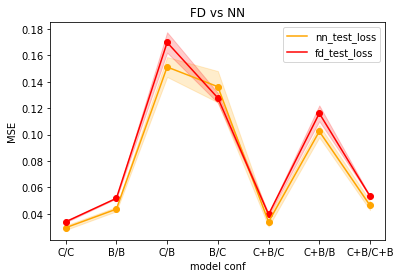

In [12]:
nn_mean = [nn_total_losses[i][0] for i in nn_total_losses.keys()]
nn_std = [nn_total_losses[i][1] for i in nn_total_losses.keys()]

fd_mean = [fd_total_losses[i][0] for i in fd_total_losses.keys()]
fd_std = [fd_total_losses[i][1] for i in fd_total_losses.keys()]

fig, ax = plt.subplots()
ax.fill_between(range(len(nn_std)), [nn_mean[i]+nn_std[i] for i in range(len(nn_std))], [nn_mean[i]-nn_std[i] for i in range(len(nn_std))], alpha=0.2, color='orange')
ax.plot(nn_mean, label='nn_test_loss', c='orange')
ax.scatter(range(len(nn_std)), nn_mean, c='orange')

ax.fill_between(range(len(fd_std)), [fd_mean[i]+fd_std[i] for i in range(len(fd_std))], [fd_mean[i]-fd_std[i] for i in range(len(fd_std))], alpha=0.2, color='red')
ax.plot(fd_mean, label='fd_test_loss', c='red')
ax.scatter(range(len(fd_mean)), fd_mean, c='red')
plt.legend()
ax.set_ylabel('MSE')
ax.set_xlabel('model conf')
ax.set_xticks(range(len(nn_mean)), labels=['C/C', 'B/B', 'C/B', 'B/C', 'C+B/C', 'C+B/B', 'C+B/C+B'])
plt.title('FD vs NN')
plt.show()

In [13]:
nn_total_losses, fd_total_losses

({'corridor_140-corridor_140': (0.029445359548438278, 0.001662765427270679),
  'bottleneck_120-bottleneck_120': (0.04353375095894638,
   0.0016345997356471162),
  'corridor_140-bottleneck_120': (0.15123135897776577, 0.007538459450141736),
  'bottleneck_120-corridor_140': (0.13630219999588997, 0.01182886243229216),
  'corridor_140+bottleneck_120-corridor_140': (0.033904850630758196,
   0.0036204205218063664),
  'corridor_140+bottleneck_120-bottleneck_120': (0.10243839015079265,
   0.0045120917555530535),
  'corridor_140+bottleneck_120-corridor_140+bottleneck_120': (0.04630034275695937,
   0.003530486337210664)},
 {'corridor_140-corridor_140': (0.033946966573227155, 0.00047368189485528215),
  'bottleneck_120-bottleneck_120': (0.051748068175014914,
   0.00019566207519946776),
  'corridor_140-bottleneck_120': (0.16984297266805815, 0.007719560454832764),
  'bottleneck_120-corridor_140': (0.12780021057112087, 0.0037107084077131324),
  'corridor_140+bottleneck_120-corridor_140': (0.0395129857